<font size = '5'>**Разработка модели предсказания популярности поста** </font>

Постановка задачи: Паблики в соцсетях являются важным инструментом для продвижения организаций. Чем больше реакций (репостов/лайков/упоминаний) тем выше популярность и узнаваемость. Нужно научиться определять что именно в постах влияет на их популярность. Вам предстоит подготовить датасет, разработать и обучить модель, после чего проанализировать важность ее признаков и их влияние популярность постов. 

Цель: Разработать модель предсказания популярности поста и подготовить отчет, в котором будут рекомендации для Заказчика по формированию поста - на что нужно больше всего обращать внимание при его создании, чтобы максимизировать его популярность.
Исходные данные: История постов с 10+ пабликов из соцсетей в CSV формате. Ссылка на данные - https://disk.yandex.ru/d/5Y3Zj2SYxPEfgw Информация о пабликах - https://docs.google.com/document/d/1bXknW30wP0ka-_w6GTGZocseT4f7PPLCLlON5s6OWHQ/edit

# Подготовка данных

In [1]:
#!pip install pymorphy2

In [2]:
import pandas as pd
import numpy as np
import phik
import re

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
import pymorphy2
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.dummy import DummyRegressor, DummyClassifier

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, roc_curve
from sklearn.metrics import confusion_matrix

import optuna
from optuna.samplers import TPESampler

import warnings

warnings.filterwarnings('ignore')
pd.options.display.max_colwidth = 200
RANDOM_STATE = 42
sampler = TPESampler(seed=42)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Генадий\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Генадий\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
vk1 = pd.read_csv('D:/vk/new_data/vk_artbazar_61.csv')
vk2 = pd.read_csv('D:/vk/new_data/vk_c52space.csv')
vk3 = pd.read_csv('D:/vk/new_data/vk_centr_step.csv')
vk4 = pd.read_csv('D:/vk/new_data/vk_d30space.csv')
vk5 = pd.read_csv('D:/vk/new_data/vk_dspl_rostov.csv')
vk6 = pd.read_csv('D:/vk/new_data/vk_makaronka_space.csv')
vk7 = pd.read_csv('D:/vk/new_data/vk_mayak.lektory.csv')
vk8 = pd.read_csv('D:/vk/new_data/vk_msiid.csv')
vk9 = pd.read_csv('D:/vk/new_data/vk_n_s_rnd.csv')
vk10 = pd.read_csv('D:/vk/new_data/vk_rostov.csv')
vk11 = pd.read_csv('D:/vk/new_data/vk_sholokhovrostov.csv')

In [4]:
tg1 = pd.read_csv('D:/vk/new_data/tg_dsplrostov.csv')
tg2 = pd.read_csv('D:/vk/new_data/tg_rostov_gallery.csv')
ns = pd.read_csv('D:/vk/new_data/n_s_rnd.csv')

In [5]:
vk1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216 entries, 0 to 1215
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      1216 non-null   int64  
 1   date            1216 non-null   object 
 2   text            1049 non-null   object 
 3   is_pinned       1216 non-null   float64
 4   attachments     1216 non-null   float64
 5   post_source     1216 non-null   object 
 6   comments        1216 non-null   int64  
 7   likes           1216 non-null   int64  
 8   reposts         1216 non-null   int64  
 9   views           1216 non-null   float64
 10  len_text        1216 non-null   int64  
 11  post_source_id  1216 non-null   int64  
 12  year            1216 non-null   int64  
 13  month           1216 non-null   int64  
 14  dayofweek       1216 non-null   int64  
 15  hour            1216 non-null   int64  
dtypes: float64(3), int64(10), object(3)
memory usage: 152.1+ KB


In [6]:
tg1.info()
tg2.info()
ns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   msg_id           937 non-null    int64 
 1   sender           937 non-null    object
 2   sender_id        937 non-null    object
 3   reply_to_msg_id  937 non-null    int64 
 4   date             937 non-null    object
 5   msg_type         937 non-null    object
 6   msg_content      937 non-null    object
 7   has_mention      937 non-null    int64 
 8   has_email        937 non-null    int64 
 9   has_phone        937 non-null    int64 
 10  has_hashtag      937 non-null    int64 
 11  is_bot_command   937 non-null    int64 
dtypes: int64(7), object(5)
memory usage: 88.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2098 entries, 0 to 2097
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   msg_id      

In [7]:
tg1.dtypes == ns.dtypes

msg_id             True
sender             True
sender_id          True
reply_to_msg_id    True
date               True
msg_type           True
msg_content        True
has_mention        True
has_email          True
has_phone          True
has_hashtag        True
is_bot_command     True
dtype: bool

In [8]:
vk1.dtypes == vk7.dtypes

Unnamed: 0         True
date               True
text               True
is_pinned          True
attachments        True
post_source        True
comments           True
likes              True
reposts            True
views             False
len_text           True
post_source_id     True
year               True
month              True
dayofweek          True
hour               True
dtype: bool

Некоторые числовые поля датасетов `vk` содержат где то данные типа int, где то float. Нам это не помешает объединить датасеты. Прежде чем объединять, удалим в датасетах vk пропущенные значения, тк там пропущено содержание самих постов, что является очень важной информацией.

In [9]:
tg_df = [tg1, tg2, ns]
tg_keys = ['dsplrostov', 'rostov_gallery', 's_rnd']
tg = pd.concat(tg_df, keys=tg_keys)

In [10]:
tg.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3888 entries, ('dsplrostov', 0) to ('s_rnd', 852)
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   msg_id           3888 non-null   int64 
 1   sender           3888 non-null   object
 2   sender_id        3888 non-null   object
 3   reply_to_msg_id  3888 non-null   int64 
 4   date             3888 non-null   object
 5   msg_type         3888 non-null   object
 6   msg_content      3888 non-null   object
 7   has_mention      3888 non-null   int64 
 8   has_email        3888 non-null   int64 
 9   has_phone        3888 non-null   int64 
 10  has_hashtag      3888 non-null   int64 
 11  is_bot_command   3888 non-null   int64 
dtypes: int64(7), object(5)
memory usage: 456.9+ KB


In [11]:
tg

msg_id            sender          sender_id  reply_to_msg_id  \
dsplrostov 0         3          Публичка  channel1698358110               -1   
           1         4          Публичка  channel1698358110               -1   
           2         5          Публичка  channel1698358110               -1   
           3         6          Публичка  channel1698358110               -1   
           4         7          Публичка  channel1698358110               -1   
...                ...               ...                ...              ...   
s_rnd      848     944  НИЧЕГО СТРАШНОГО  channel1486494176               -1   
           849     945  НИЧЕГО СТРАШНОГО  channel1486494176               -1   
           850     946  НИЧЕГО СТРАШНОГО  channel1486494176               -1   
           851     947  НИЧЕГО СТРАШНОГО  channel1486494176               -1   
           852     948  НИЧЕГО СТРАШНОГО  channel1486494176               -1   

                               date msg_type  \
dsplrostov 0    2022-03-01 11:55:15     text   
           1    2022-03-01 14:00:21    photo   
           2    2022-03-01 15:56:34    photo   
           3    2022-03-01 15:56:34    photo   
           4    2022-03-01 16:00:46     text   
...                             ...      ...   
s_rnd      848  2022-12-08 23:09:41    photo   
           849  2022-12-08 23:09:41    photo   
           850  2022-12-08 23:09:41    photo   
           851  2022-12-15 14:19:55    photo   
           852  2022-12-30 13:57:47     link   

                                                                                                                                                                                                            msg_content  \
dsplrostov 0                             Дорогие друзья, теперь у нас появился телеграм-канал📱  Здесь мы будем информировать вас о самых интересных событиях библиотеки 👌👌 и, конечно, ждать обратной связи!  Welcome 🤗   
           1                                                                                                                                           (File not included. Change data exporting settings to download.)   
           2                                                                                                                                           (File not included. Change data exporting settings to download.)   
           3                                                                                                                                           (File not included. Change data exporting settings to download.)   
           4    ❗Не забываем, что при посещении библиотеки необходимо предъявить QR-код либо сертификат, подтверждающий прививку от COVID-19, или справку либо сертификат о перенесенном коронавирусе (не позднее 6 ...   
...                                                                                                                                                                                                                 ...   
s_rnd      848                                                                                                                                         (File not included. Change data exporting settings to download.)   
           849                                                                                                                                         (File not included. Change data exporting settings to download.)   
           850                                                                                                                                         (File not included. Change data exporting settings to download.)   
           851                                                                                                                                         (File not included. Change data exporting settings to download.)   
           852                                                       

In [12]:
vk_df = [vk1, vk2, vk3, vk4, vk5, vk6, vk7, vk8, vk9, vk10, vk11]
vk_keys = ['artbazar_61', 'c52space', 'centr_step', 'd30space', 'dspl_rostov', 'makaronka_space',
           'mayak.lektory', 'msiid', 'n_s_rnd', 'rostov', 'sholokhovrostov']
for df in vk_df:
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
vk = pd.concat(vk_df, keys=vk_keys)
vk = vk.drop('Unnamed: 0', axis=1)

In [13]:
vk.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 12402 entries, ('artbazar_61', 0) to ('sholokhovrostov', 503)
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            12402 non-null  object 
 1   text            12402 non-null  object 
 2   is_pinned       12402 non-null  float64
 3   attachments     12402 non-null  float64
 4   post_source     12402 non-null  object 
 5   comments        12402 non-null  int64  
 6   likes           12402 non-null  int64  
 7   reposts         12402 non-null  float64
 8   views           12402 non-null  float64
 9   len_text        12402 non-null  int64  
 10  post_source_id  12402 non-null  int64  
 11  year            12402 non-null  int64  
 12  month           12402 non-null  int64  
 13  dayofweek       12402 non-null  int64  
 14  hour            12402 non-null  int64  
dtypes: float64(4), int64(8), object(3)
memory usage: 1.6+ MB


In [14]:
vk

date  \
artbazar_61     0    2022-11-03 11:06:58   
                1    2023-02-15 10:42:46   
                2    2023-02-06 13:41:00   
                3    2023-02-06 12:41:00   
                4    2023-02-06 11:41:00   
...                                  ...   
sholokhovrostov 499  2016-01-20 11:51:26   
                500  2016-01-20 11:49:12   
                501  2016-01-20 11:47:33   
                502  2016-01-14 13:05:22   
                503  2016-01-14 12:39:52   

                                                                                                                                                                                                                        text  \
artbazar_61     0                                 Неудобно листать стену, чтобы найти мероприятие на конкретную дату?\n\nАфиша всех опубликованных мероприятий по датам в обсуждении\nhttps://vk.com/topic-23746107_49180355   
                1    18 февраля в 19-30\n[club8931856|СкитЪ] представит свою полную программу. \nВ концерте так же примут участие наши друзья [id99262820|Вячеслав Захаров] - Человек-Трава и [id3245231|Наталья Верба] -...   
                2                                                            концерт Ильи Соболева\n \n📆 16 февраля в 19:00\n🚩 Пересвет-арена (ул. Целиноградская 3) \n🎫 Купить билет: https://vk.cc/cllmWn\n💵 2000 — 4500 ₽   
                3    День Дурака\n \n📆 14 Февраля в 19:00 \n🚩 Конгресс-холл ДГТУ (пл. Гагарина, 1)\n🎫 Купить билет: https://vk.cc/cllmRx\n💵 1200 — 4000 ₽\n\n1 апреля – прекрасный денёк для преступления века! Шестеро ч...   
                4    Большой концерт Ани Лорак «THE BEST» \n\n📆 26 Апреля в 19:00 \n🚩 КСК Экспресс (ул. Закруткина, 67А)\n🎫 Купить билет: https://vk.cc/cllmO2\n💵 1500 — 7000 ₽\n\nВсе ранее купленные билеты действитель...   
...                                                                                                                                                                                                                      ...   
sholokhovrostov 499  12 июня - 18 сентября 2016 г.\n"ДОМ И МИР НА ПОЛЯРНОМ КРУГЕ"\n\nЯмало-Ненецкий окружной музейно-выставочный комплекс им. И.С. Шемановского\n\nЭкспозиция строится на показе культур оленеводов тундр...   
                500  30 сентября - 4 декабря\n"ТУТ БЫЛ Я СЧАСТЛИВ..."\n\nГосударственный Лермонтовский музей-заповедник «Тарханы»\nГосударственный музей-заповедник М.Ю.Лермонтова (Пятигорск)\nЛитературный музей Инстит...   
                501  16 ДЕКАБРЯ 2016 - 28 ФЕВРАЛЯ 2017 года\n"ГИМН РОССИИ"\n\nВсероссийское музейное объединение музыкальной культуры им. Глинки (Москва)\n\n«Гимн России», где представлена история Государственного гим...   
                502  Почувствуйте себя настоящими кондитерами и ощутите сладкий вкус шоколадной конфеты, созданной своими руками! \nПриходите поэкспериментрировать в нашей "Шоколадной лаборатории"!\nhttp://www.sholokh...   
                503                                                                                                                                                    Приглашаем посетить выставку "Рождественские истории"   

                     is_pinned  attachments post_source  comments  likes  \
artbazar_61     0          1.0          1.0          vk         2      6   
                1          0.0          1.0          vk         0     20   
                2          0.0          1.0          vk         0      2   
                3          0.0          1.0          vk         0      1   
                4          0.0          1.0          vk         0      1   
...                        ...          ...         ...       ...    ...   
sholokhovrostov 499        0.0          3.0          vk         0      2   
                500        0.0          2.0          vk         0      4   
                501        0.0          3.0          vk         0      2   
                502        0.0          6.0          vk   

Почистили от пропущенных значений и объединили датафреймы. По vk видно, что столбцы `date` (в датафрейме уже есть инфо в др столбцах), и `post_source`, скорее всего, можно выкинуть. В tg это столбец `msg_id`. Проверим на дубликаты и аномалии.

In [15]:
vk.post_source.unique() #Пока не дропаем, пока не изучим корреляцию с ЦП

array(['vk', 'api', 'mvk'], dtype=object)

In [16]:
vk = vk.drop('date', axis=1)
tg = tg.drop('msg_id', axis=1)

Приведу поля в ВК с типом float к int, тк значения по логике целочисленные.

In [17]:
vk[['is_pinned', 'attachments', 'reposts', 'views']] = vk[['is_pinned', 'attachments', 'reposts', 'views']].astype('int')

In [18]:
vk.duplicated().sum()

1

Один дубликат в ВК удалять не будем.

In [19]:
tg.duplicated().sum()

1475

Такое большое количество дубликатов в ТГ связано с тем, что много картинок с одинаковыми показателями, но посты разные.

In [20]:
tg.msg_type.unique()

array(['text', 'photo', 'link', 'video_file', 'animation', 'file',
       'sticker', 'video_message', 'poll'], dtype=object)

Из того, что мы видим, имеет смысл дальше работать только с vk. В tg нету никаких фич, которые можно было бы признать целевыми, на основании которых мы могли бы судить о популярности или непопулярности поста.

In [21]:
vk.describe()

,is_pinned,attachments,comments,likes,reposts,views,len_text,post_source_id,year,month,dayofweek,hour
count,12402.000000,12402.000000,12402.000000,12402.000000,12402.000000,12402.000000,12402.000000,12402.000000,12402.000000,12402.000000,12402.000000,12402.000000
mean,0.000242,1.666183,0.432430,12.469360,1.926302,550.485486,726.492662,0.803499,2019.171343,6.529995,2.588615,10.990405
std,0.015552,1.884068,2.024005,24.236029,3.984878,1004.559897,981.140934,0.397367,2.931039,3.535019,1.765987,3.748438
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2011.000000,1.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,4.000000,0.000000,131.000000,166.000000,1.000000,2018.000000,3.000000,1.000000,8.000000
50%,0.000000,1.000000,0.000000,8.000000,1.000000,356.000000,455.000000,1.000000,2020.000000,6.000000,3.000000,10.000000
75%,0.000000,2.000000,0.000000,15.000000,2.000000,719.000000,914.000000,1.000000,2022.000000,10.000000,4.000000,13.000000
max,1.000000,10.000000,105.000000,2009.000000,114.000000,58951.000000,16087.000000,1.000000,2023.000000,12.000000,6.000000,23.000000


При беглом ознакомлении аномалий не обнаружено.

In [22]:
vk.loc[vk['comments'] == 10]

text  \
c52space    406   Эй, ты живёшь в Ростове и хочешь познакомиться с Сансёрферами☀🏄? Тогда этот анонс для тебя! \n👍👍👍👍👍 \n\n10 Декабря в 16.00 в Главном зале центра "Кластер C52" пройдет первый MeetUp — встреча Сансё...   
            1442  Уважаемые студенты творческих специальностей, если перед вами стоит вопрос о прохождении летней практики в мастерских(рабочая практика), Креативное пространство предоставляет вам возможность пройт...   
            1500  Член команды проекта [club37106921|Ночь Карьеры/ Career night], ответственный за  работу с компаниями,  [id5299634|Елена Шереметцева] составила плейлист из своих любимых композиций специально для ...   
            1622                                                                                                                              Спасибо ребятам из проката и Павлу Платонову за баки для сортировки мусора!   
dspl_rostov 843   28 мая Донская публичная библиотека станет участником всероссийской акции в поддержку чтения - «Библионочь – 2022». Концепция акции напрямую связана с проведением Года культурного наследия народов...   
            1909  1 мая состоялось открытие возрожденного фонтана Публички, реконструкция которого была инициирована Губернатором Ростовской области Голубевым Василием Юрьевичем. В церемонии открытия приняли участи...   
            2440                                                                                                                                                                             Онлайн-концерт "Библиоджаз!"   

                  is_pinned  attachments post_source  comments  likes  \
c52space    406           0            0         api        10      4   
            1442          0            0          vk        10     48   
            1500          0            8          vk        10     34   
            1622          0            0          vk        10     18   
dspl_rostov 843           0            1          vk        10    107   
            1909          0           10          vk        10    112   
            2440          0            1          vk        10     34   

                  reposts  views  len_text  post_source_id  year  month  \
c52space    406         1   2313       675               0  2017     12   
            1442       16      0       511               1  2013      6   
            1500        4      0       315               1  2013      4   
            1622        2      0        75               1  2012      9   
dspl_rostov 843        45   3334      1018               1  2022      5   
            1909       42   1965      1500               1  2021      5   
            2440        8   1058        28               1  2020     11   

                  dayofweek  hour  
c52space    406           1     7  
            1442          2    12  
            1500          1     9  
            1622          2    16  
dspl_rostov 843           3    11  
            1909          6     7  
            2440          2    14

In [23]:
vk.loc[vk['views'] == 0]

text  \
artbazar_61     981  Сегодня – Йоль, самая длинная, самая тёмная ночь года. Ночь, в которую всё возможно, и ночь, когда тайное меняется местом с явным.\nНа минуту подняв глаза от текста, который я делаю, я вижу алую, ...   
                982                                                                                                                                                                                                 Знакомо?   
                983                                                                                                                        Ураааааа!! Нас 3000 человек!! Спасибо всем и каждому в отдельности,что вы с нами!   
                984                                                                                                                                   Головоломка «Найди панду» от венгерского художника Дудольфа.\nНашли? 😉   
                985                                                                                                                                                                                язык жестов по-новому \n😃   
...                                                                                                                                                                                                                      ...   
sholokhovrostov 499  12 июня - 18 сентября 2016 г.\n"ДОМ И МИР НА ПОЛЯРНОМ КРУГЕ"\n\nЯмало-Ненецкий окружной музейно-выставочный комплекс им. И.С. Шемановского\n\nЭкспозиция строится на показе культур оленеводов тундр...   
                500  30 сентября - 4 декабря\n"ТУТ БЫЛ Я СЧАСТЛИВ..."\n\nГосударственный Лермонтовский музей-заповедник «Тарханы»\nГосударственный музей-заповедник М.Ю.Лермонтова (Пятигорск)\nЛитературный музей Инстит...   
                501  16 ДЕКАБРЯ 2016 - 28 ФЕВРАЛЯ 2017 года\n"ГИМН РОССИИ"\n\nВсероссийское музейное объединение музыкальной культуры им. Глинки (Москва)\n\n«Гимн России», где представлена история Государственного гим...   
                502  Почувствуйте себя настоящими кондитерами и ощутите сладкий вкус шоколадной конфеты, созданной своими руками! \nПриходите поэкспериментрировать в нашей "Шоколадной лаборатории"!\nhttp://www.sholokh...   
                503                                                                                                                                                    Приглашаем посетить выставку "Рождественские истории"   

                     is_pinned  attachments post_source  comments  likes  \
artbazar_61     981          0            1         api         0      8   
                982          0            1         api         0     10   
                983          0            1         api         0      2   
                984          0            1         api         2     10   
                985          0            5          vk         1     36   
...                        ...          ...         ...       ...    ...   
sholokhovrostov 499          0            3          vk         0      2   
                500          0            2          vk         0      4   
                501          0            3          vk         0      2   
                502          0            6          vk         0      2   
                503          0            3          vk         0      2   

                     reposts  views  len_text  post_source_id  year  month  \
artbazar_61     981        0      0       970               0  2016     12   
                982        1      0         8               0  2016     12   
                983        0      0        81               0  2016     12   
                984        0      0        69               0  2016     12   
                985        5      0        24               1  2016     12   
...                      ...    ...       ...             ...   ...    ...   
sholokhovrostov 499        0      0       820               1  2016 

In [24]:
vk.loc[vk['is_pinned'] == 1]

,,text,is_pinned,attachments,post_source,comments,likes,reposts,views,len_text,post_source_id,year,month,dayofweek,hour
artbazar_61,0,"Неудобно листать стену, чтобы найти мероприятие на конкретную дату?\n\nАфиша всех опубликованных мероприятий по датам в обсуждении\nhttps://vk.com/topic-23746107_49180355",1,1,vk,2,6,2,1575,167,1,2022,11,3,11
mayak.lektory,0,"Свежее вдохновляющее расписание, новое место и время встреч. Февраль — месяц прекрасных перемен ❤️\n\nДорогие любители интеллектуального отдыха, сегодня хотим поблагодарить вас за диалог и обратну...",1,10,api,2,10,6,436,734,0,2023,1,2,17
rostov,0,4 февраля в 16:00 у нас начнет работу персональная выставка «Избранное» художника Сергея Ковалевского-MISSER.\nВ экспозиции будут представлены живописные полотна автора из проектов: «Применяемость...,1,1,api,8,70,32,1750,742,0,2023,2,3,7


Столбец `is_pinned` содержит одни нули и не содержателен.

In [25]:
vk = vk.drop('is_pinned', axis=1)

Удалим строки, где нулевые значения просмотров, тк это аномалии. Также нам известно, что до апреля 2017 года не работала система подсчета просмотров. Значит данные до этой даты нужно удалить.

In [26]:
vk.loc[(vk['views'] < vk['likes']) | (vk['views'] == 0), 'views'] = np.nan
vk.loc[(vk['year'] < 2018) & (vk['month'] < 5), 'views'] = np.nan
vk = vk.dropna()

In [27]:
vk.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9871 entries, ('artbazar_61', 0) to ('sholokhovrostov', 456)
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   text            9871 non-null   object 
 1   attachments     9871 non-null   int32  
 2   post_source     9871 non-null   object 
 3   comments        9871 non-null   int64  
 4   likes           9871 non-null   int64  
 5   reposts         9871 non-null   int32  
 6   views           9871 non-null   float64
 7   len_text        9871 non-null   int64  
 8   post_source_id  9871 non-null   int64  
 9   year            9871 non-null   int64  
 10  month           9871 non-null   int64  
 11  dayofweek       9871 non-null   int64  
 12  hour            9871 non-null   int64  
dtypes: float64(1), int32(2), int64(8), object(2)
memory usage: 1.1+ MB


In [28]:
colors = sns.color_palette('pastel')
sns.set(rc={'figure.figsize':(15, 5)}, palette=colors) #Задам настройки таблиц

interval columns not set, guessing: ['attachments', 'comments', 'likes', 'reposts', 'views', 'len_text', 'post_source_id', 'year', 'month', 'dayofweek', 'hour']


<AxesSubplot:>

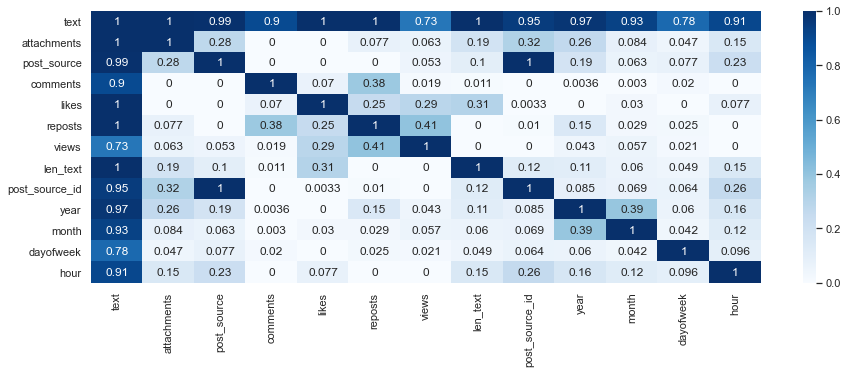

In [29]:
sns.heatmap(vk.phik_matrix(), annot=True, cmap='Blues')

Репосты высоко коррелируют с комментами и с просмотрами, лайки с длиной текста. Судя по всему, в определенные годы был бум постов с вложениями. Вложения также коррелируют с источником поста.

In [30]:
vk['metrics'] = (vk['likes'] / vk['views'])

Создали метрику, которая приблизительно оценивает популярность поста. В качестве такой метрики я выбрал конверсию лайков на просмотры, тк, на мой взгляд, такая практика лучше всего отражает популярность поста, насколько он нравится людям.

In [31]:
vk

text  \
artbazar_61     0                                 Неудобно листать стену, чтобы найти мероприятие на конкретную дату?\n\nАфиша всех опубликованных мероприятий по датам в обсуждении\nhttps://vk.com/topic-23746107_49180355   
                1    18 февраля в 19-30\n[club8931856|СкитЪ] представит свою полную программу. \nВ концерте так же примут участие наши друзья [id99262820|Вячеслав Захаров] - Человек-Трава и [id3245231|Наталья Верба] -...   
                2                                                            концерт Ильи Соболева\n \n📆 16 февраля в 19:00\n🚩 Пересвет-арена (ул. Целиноградская 3) \n🎫 Купить билет: https://vk.cc/cllmWn\n💵 2000 — 4500 ₽   
                3    День Дурака\n \n📆 14 Февраля в 19:00 \n🚩 Конгресс-холл ДГТУ (пл. Гагарина, 1)\n🎫 Купить билет: https://vk.cc/cllmRx\n💵 1200 — 4000 ₽\n\n1 апреля – прекрасный денёк для преступления века! Шестеро ч...   
                4    Большой концерт Ани Лорак «THE BEST» \n\n📆 26 Апреля в 19:00 \n🚩 КСК Экспресс (ул. Закруткина, 67А)\n🎫 Купить билет: https://vk.cc/cllmO2\n💵 1500 — 7000 ₽\n\nВсе ранее купленные билеты действитель...   
...                                                                                                                                                                                                                      ...   
sholokhovrostov 452  ❗Дорогие друзья! \nНаше сотрудничество с музеем "Шолохов-Центр" продолжается! \nМы рады пригласить вас на удивительный вечер, в течение которого вы сможете посмотреть сразу два (!) наших спектакля...   
                453  24 мая 2017 года в 12.00 в «Шолохов-Центре» Государственного музея-заповедника М.А. Шолохова в рамках культурно-просветительского проекта «Театр в музее» состоится спектакль «Нахаленок» по мотивам...   
                454                                                                                                                                                       "Шолохов-Центр" приглашает провести "Ночь в музее"   
                455  В «Шолохов-Центре» Государственного музея-заповедника М.А.Шолохова 28 апреля 2017 года состоялся финал серии интеллектуальных игр «Весенний филин-2017», в котором приняли участие 9 команд, успешно...   
                456  ИНТЕЛЛЕКТУАЛЬНЫЕ БОИ В "ШОЛОХОВ-ЦЕНТРЕ" \n\n28 апреля 2017 горда в «Шолохов-Центре» Государственного музея-заповедника М.А. Шолохова состоялся финал весенней серии интеллектуальных игр «Весенний ф...   

                     attachments post_source  comments  likes  reposts  \
artbazar_61     0              1          vk         2      6        2   
                1              1          vk         0     20        9   
                2              1          vk         0      2        2   
                3              1          vk         0      1        1   
                4              1          vk         0      1        1   
...                          ...         ...       ...    ...      ...   
sholokhovrostov 452            1          vk         0      2        0   
                453            1          vk         0      9        2   
                454            2          vk         0     37       12   
                455            1          vk         0      4        0   
                456            5          vk         0      6        0   

                      views  len_text  post_source_id  year  month  dayofweek  \
artbazar_61     0    1575.0       167               1  2022     11          3   
                1     624.0      1350               1  2023      2          2   
                2     372.0       138               1  2023      2          0   
                3     473.0      1055               1  2023      2          0   
                4     291.0       908               1  2023      2          0   
...                     ...       ...             ...   ...    ...        ...   
sholokhovrostov 452   221.0       778               1  2017      5     

In [32]:
vk.describe()

,attachments,comments,likes,reposts,views,len_text,post_source_id,year,month,dayofweek,hour,metrics
count,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000
mean,1.726775,0.394793,13.238780,2.049742,668.698308,802.792929,0.777328,2020.392767,6.619289,2.626583,10.775808,0.023256
std,1.858198,1.903617,26.452102,4.277419,1079.419274,1040.447723,0.416061,1.615911,3.527304,1.763918,3.628393,0.018310
min,0.000000,0.000000,0.000000,0.000000,11.000000,1.000000,0.000000,2017.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,4.000000,0.000000,258.000000,208.000000,1.000000,2019.000000,4.000000,1.000000,8.000000,0.011070
50%,1.000000,0.000000,8.000000,1.000000,446.000000,527.000000,1.000000,2021.000000,6.000000,3.000000,10.000000,0.019469
75%,2.000000,0.000000,15.000000,2.000000,836.500000,986.000000,1.000000,2022.000000,10.000000,4.000000,13.000000,0.030963
max,10.000000,105.000000,2009.000000,114.000000,58951.000000,16087.000000,1.000000,2023.000000,12.000000,6.000000,23.000000,0.509511


<AxesSubplot:xlabel='metrics'>

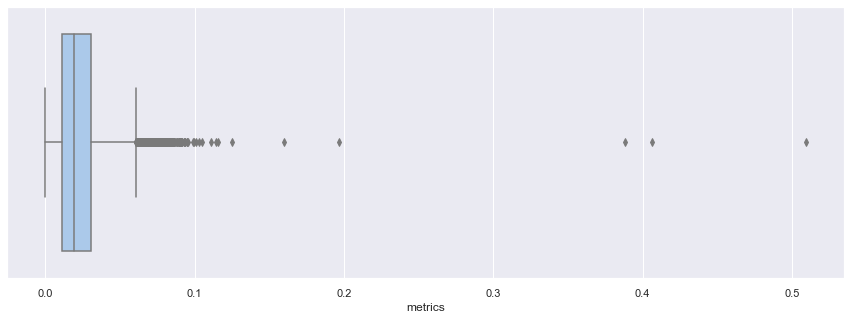

In [33]:
sns.boxplot(vk['metrics'])

Удалим выбросы.

In [34]:
vk.drop(vk.loc[vk['metrics'] > 0.08].index, inplace=True)
vk.shape

(9798, 14)

Нужно создать дополнительно метрику классификации. Пускай это будет бинарная классификация, где 1 - популярен, 0 - не популярен. В качестве порога популярности возьмем значение чуть выше среднего.

In [35]:
MEAN = vk['metrics'].mean() + 0.005
vk['metrics_classifier'] = vk['metrics'].apply(lambda x: 1 if x > MEAN else 0)
vk.head(5)

text  \
artbazar_61 0                               Неудобно листать стену, чтобы найти мероприятие на конкретную дату?\n\nАфиша всех опубликованных мероприятий по датам в обсуждении\nhttps://vk.com/topic-23746107_49180355   
            1  18 февраля в 19-30\n[club8931856|СкитЪ] представит свою полную программу. \nВ концерте так же примут участие наши друзья [id99262820|Вячеслав Захаров] - Человек-Трава и [id3245231|Наталья Верба] -...   
            2                                                          концерт Ильи Соболева\n \n📆 16 февраля в 19:00\n🚩 Пересвет-арена (ул. Целиноградская 3) \n🎫 Купить билет: https://vk.cc/cllmWn\n💵 2000 — 4500 ₽   
            3  День Дурака\n \n📆 14 Февраля в 19:00 \n🚩 Конгресс-холл ДГТУ (пл. Гагарина, 1)\n🎫 Купить билет: https://vk.cc/cllmRx\n💵 1200 — 4000 ₽\n\n1 апреля – прекрасный денёк для преступления века! Шестеро ч...   
            4  Большой концерт Ани Лорак «THE BEST» \n\n📆 26 Апреля в 19:00 \n🚩 КСК Экспресс (ул. Закруткина, 67А)\n🎫 Купить билет: https://vk.cc/cllmO2\n💵 1500 — 7000 ₽\n\nВсе ранее купленные билеты действитель...   

               attachments post_source  comments  likes  reposts   views  \
artbazar_61 0            1          vk         2      6        2  1575.0   
            1            1          vk         0     20        9   624.0   
            2            1          vk         0      2        2   372.0   
            3            1          vk         0      1        1   473.0   
            4            1          vk         0      1        1   291.0   

               len_text  post_source_id  year  month  dayofweek  hour  \
artbazar_61 0       167               1  2022     11          3    11   
            1      1350               1  2023      2          2    10   
            2       138               1  2023      2          0    13   
            3      1055               1  2023      2          0    12   
            4       908               1  2023      2          0    11   

                metrics  metrics_classifier  
artbazar_61 0  0.003810                   0  
            1  0.032051                   1  
            2  0.005376                   0  
            3  0.002114                   0  
            4  0.003436                   0

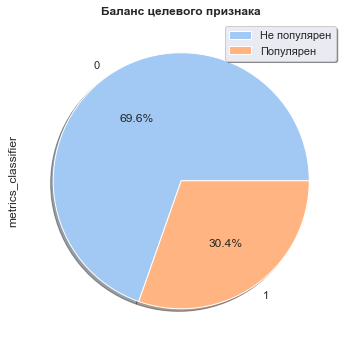

In [36]:
#Узнаем долю популярных постов
vk['metrics_classifier'].value_counts().plot(kind='pie', shadow=True, autopct='%1.1f%%')
plt.legend(['Не популярен', 'Популярен'], shadow=True)
plt.title('Баланс целевого признака', fontweight="bold")
plt.tight_layout()
plt.show()

Мы подготовили датафрейм. Сохраним его для новых исследований.

In [37]:
path = 'D:/vk/new_data/vk.csv'
vk.to_csv(path)

# Подготовка признаков

Теперь нам нужно подготовить посты к обучению.

In [38]:
def text_cleaner(data): #Убираем лишние знаки, оставляем только слова
    data = re.sub(r'[^A-Za-zА-ЯЁа-яё-]+', ' ', data)
    return data
vk['text'] = vk['text'].apply(text_cleaner)
vk['text'] = vk['text'].str.lower()

In [39]:
vk

text  \
artbazar_61     0                                                         неудобно листать стену чтобы найти мероприятие на конкретную дату афиша всех опубликованных мероприятий по датам в обсуждении https vk com topic-    
                1     февраля в - club скитъ представит свою полную программу в концерте так же примут участие наши друзья id вячеслав захаров - человек-трава и id наталья верба - танцы солнце и морской ветер на раско...   
                2                                                                                                          концерт ильи соболева февраля в пересвет-арена ул целиноградская купить билет https vk cc cllmwn    
                3    день дурака февраля в конгресс-холл дгту пл гагарина купить билет https vk cc cllmrx апреля прекрасный денёк для преступления века шестеро чудиков неудачников и придурков всех мастей очутились на ...   
                4    большой концерт ани лорак the best апреля в кск экспресс ул закруткина а купить билет https vk cc cllmo все ранее купленные билеты действительны и обмену не подлежат самая востребованная певица со...   
...                                                                                                                                                                                                                      ...   
sholokhovrostov 452   дорогие друзья наше сотрудничество с музеем шолохов-центр продолжается мы рады пригласить вас на удивительный вечер в течение которого вы сможете посмотреть сразу два наших спектакля пиковая дама...   
                453   мая года в в шолохов-центре государственного музея-заповедника м а шолохова в рамках культурно-просветительского проекта театр в музее состоится спектакль нахаленок по мотивам одноименного расска...   
                454                                                                                                                                                          шолохов-центр приглашает провести ночь в музее    
                455  в шолохов-центре государственного музея-заповедника м а шолохова апреля года состоялся финал серии интеллектуальных игр весенний филин- в котором приняли участие команд успешно прошедших отборочны...   
                456  интеллектуальные бои в шолохов-центре апреля горда в шолохов-центре государственного музея-заповедника м а шолохова состоялся финал весенней серии интеллектуальных игр весенний филин- в финале при...   

                     attachments post_source  comments  likes  reposts  \
artbazar_61     0              1          vk         2      6        2   
                1              1          vk         0     20        9   
                2              1          vk         0      2        2   
                3              1          vk         0      1        1   
                4              1          vk         0      1        1   
...                          ...         ...       ...    ...      ...   
sholokhovrostov 452            1          vk         0      2        0   
                453            1          vk         0      9        2   
                454            2          vk         0     37       12   
                455            1          vk         0      4        0   
                456            5          vk         0      6        0   

                      views  len_text  post_source_id  year  month  dayofweek  \
artbazar_61     0    1575.0       167               1  2022     11          3   
                1     624.0      1350               1  2023      2          2   
                2     372.0       138               1  2023      2          0   
                3     473.0      1055               1  2023      2          0   
                4     291.0       908               1  2023      2          0   
...                     ...       ...             ...   ...    ...        ...   
sholokhovrostov 452   221.0       778               1  2017      5     

In [40]:
vk['text'] = vk.apply(lambda row: nltk.word_tokenize(row['text'], language='russian'), axis=1) #Токенизация
vk.head(5)

text  \
artbazar_61 0                                  [неудобно, листать, стену, чтобы, найти, мероприятие, на, конкретную, дату, афиша, всех, опубликованных, мероприятий, по, датам, в, обсуждении, https, vk, com, topic-]   
            1  [февраля, в, -, club, скитъ, представит, свою, полную, программу, в, концерте, так, же, примут, участие, наши, друзья, id, вячеслав, захаров, -, человек-трава, и, id, наталья, верба, -, танцы, сол...   
            2                                                                                          [концерт, ильи, соболева, февраля, в, пересвет-арена, ул, целиноградская, купить, билет, https, vk, cc, cllmwn]   
            3  [день, дурака, февраля, в, конгресс-холл, дгту, пл, гагарина, купить, билет, https, vk, cc, cllmrx, апреля, прекрасный, денёк, для, преступления, века, шестеро, чудиков, неудачников, и, придурков,...   
            4  [большой, концерт, ани, лорак, the, best, апреля, в, кск, экспресс, ул, закруткина, а, купить, билет, https, vk, cc, cllmo, все, ранее, купленные, билеты, действительны, и, обмену, не, подлежат, с...   

               attachments post_source  comments  likes  reposts   views  \
artbazar_61 0            1          vk         2      6        2  1575.0   
            1            1          vk         0     20        9   624.0   
            2            1          vk         0      2        2   372.0   
            3            1          vk         0      1        1   473.0   
            4            1          vk         0      1        1   291.0   

               len_text  post_source_id  year  month  dayofweek  hour  \
artbazar_61 0       167               1  2022     11          3    11   
            1      1350               1  2023      2          2    10   
            2       138               1  2023      2          0    13   
            3      1055               1  2023      2          0    12   
            4       908               1  2023      2          0    11   

                metrics  metrics_classifier  
artbazar_61 0  0.003810                   0  
            1  0.032051                   1  
            2  0.005376                   0  
            3  0.002114                   0  
            4  0.003436                   0

In [41]:
stop_words1 = stopwords.words('russian') #Стоп-слова
stop_words2 = stopwords.words('english')
stop_words3 = stopwords.words('german')
stop_words = stop_words1 + stop_words2 + stop_words3
vk['text'] = vk['text'].apply(lambda x: [item for item in x if item not in stop_words and len(item) > 1])
vk.head(5)

text  \
artbazar_61 0                                                          [неудобно, листать, стену, найти, мероприятие, конкретную, дату, афиша, опубликованных, мероприятий, датам, обсуждении, https, vk, com, topic-]   
            1  [февраля, club, скитъ, представит, полную, программу, концерте, примут, участие, наши, друзья, id, вячеслав, захаров, человек-трава, id, наталья, верба, танцы, солнце, морской, ветер, раскопках, д...   
            2                                                                                             [концерт, ильи, соболева, февраля, пересвет-арена, ул, целиноградская, купить, билет, https, vk, cc, cllmwn]   
            3  [день, дурака, февраля, конгресс-холл, дгту, пл, гагарина, купить, билет, https, vk, cc, cllmrx, апреля, прекрасный, денёк, преступления, века, шестеро, чудиков, неудачников, придурков, мастей, оч...   
            4  [большой, концерт, ани, лорак, best, апреля, кск, экспресс, ул, закруткина, купить, билет, https, vk, cc, cllmo, ранее, купленные, билеты, действительны, обмену, подлежат, самая, востребованная, п...   

               attachments post_source  comments  likes  reposts   views  \
artbazar_61 0            1          vk         2      6        2  1575.0   
            1            1          vk         0     20        9   624.0   
            2            1          vk         0      2        2   372.0   
            3            1          vk         0      1        1   473.0   
            4            1          vk         0      1        1   291.0   

               len_text  post_source_id  year  month  dayofweek  hour  \
artbazar_61 0       167               1  2022     11          3    11   
            1      1350               1  2023      2          2    10   
            2       138               1  2023      2          0    13   
            3      1055               1  2023      2          0    12   
            4       908               1  2023      2          0    11   

                metrics  metrics_classifier  
artbazar_61 0  0.003810                   0  
            1  0.032051                   1  
            2  0.005376                   0  
            3  0.002114                   0  
            4  0.003436                   0

In [42]:
%%time
lemmatizer = pymorphy2.MorphAnalyzer() #Лемматизация
vk['text'] = vk['text'].apply(lambda x: [lemmatizer.parse(word)[0][2] for word in x])
vk.head(5)

CPU times: total: 1min 32s
Wall time: 1min 32s


text  \
artbazar_61 0                                                             [неудобно, листать, стена, найти, мероприятие, конкретный, дата, афиша, опубликовать, мероприятие, дата, обсуждение, https, vk, com, topic-]   
            1  [февраль, club, скитъ, представить, полный, программа, концерт, принять, участие, наш, друг, id, вячеслав, захаров, человек-трава, id, наталья, верба, танец, солнце, морской, ветер, раскопка, древ...   
            2                                                                                              [концерт, илья, соболев, февраль, пересвет-арена, ул, целиноградский, купить, билет, https, vk, cc, cllmwn]   
            3  [день, дурак, февраль, конгресс-холл, дгт, пл, гагарин, купить, билет, https, vk, cc, cllmrx, апрель, прекрасный, денёк, преступление, век, шестеро, чудик, неудачник, придурок, масть, очутиться, н...   
            4  [большой, концерт, ани, лорак, best, апрель, кск, экспресс, ул, закруткин, купить, билет, https, vk, cc, cllmo, ранее, купить, билет, действительный, обмен, подлежать, самый, востребовать, певица,...   

               attachments post_source  comments  likes  reposts   views  \
artbazar_61 0            1          vk         2      6        2  1575.0   
            1            1          vk         0     20        9   624.0   
            2            1          vk         0      2        2   372.0   
            3            1          vk         0      1        1   473.0   
            4            1          vk         0      1        1   291.0   

               len_text  post_source_id  year  month  dayofweek  hour  \
artbazar_61 0       167               1  2022     11          3    11   
            1      1350               1  2023      2          2    10   
            2       138               1  2023      2          0    13   
            3      1055               1  2023      2          0    12   
            4       908               1  2023      2          0    11   

                metrics  metrics_classifier  
artbazar_61 0  0.003810                   0  
            1  0.032051                   1  
            2  0.005376                   0  
            3  0.002114                   0  
            4  0.003436                   0

In [43]:
pd.options.display.max_colwidth = 1000000
print(vk.loc[('artbazar_61', 4)])
pd.options.display.max_colwidth = 200

text                  [большой, концерт, ани, лорак, best, апрель, кск, экспресс, ул, закруткин, купить, билет, https, vk, cc, cllmo, ранее, купить, билет, действительный, обмен, подлежать, самый, востребовать, певица, современность, див, ани, лорак, показать, новый, особенный, концертный, программа, название, best, говорить, сам, концерт, состоять, хороший, хит, весь, любимый, песня, также, премьер, новый, альбом, артистка, релиз, который, состояться, недавно, голос, ани, лорак, способный, перевернуть, сознание, вернуть, вера, её, искренность, оставлять, равнодушный, никто, ощущение, волшебство, оставаться, сердце, каждый, зритель, побывать, концерт, сочетание, качественный, музыка, живой, звук, завораживать, хореографический, постановка, оригинальный, костюм, мощный, голос, невероятный, красота, всё, это, ждать, предстоящий, шоу]
attachments                                                                                                                                                 

In [44]:
vk['text'] = vk['text'].apply(lambda row: ' '.join(row)) #Объединение
vk.head(5)

text  \
artbazar_61 0                                                                              неудобно листать стена найти мероприятие конкретный дата афиша опубликовать мероприятие дата обсуждение https vk com topic-   
            1  февраль club скитъ представить полный программа концерт принять участие наш друг id вячеслав захаров человек-трава id наталья верба танец солнце морской ветер раскопка древнегреческий город танаис...   
            2                                                                                                            концерт илья соболев февраль пересвет-арена ул целиноградский купить билет https vk cc cllmwn   
            3  день дурак февраль конгресс-холл дгт пл гагарин купить билет https vk cc cllmrx апрель прекрасный денёк преступление век шестеро чудик неудачник придурок масть очутиться необитаемый остров вляпать...   
            4  большой концерт ани лорак best апрель кск экспресс ул закруткин купить билет https vk cc cllmo ранее купить билет действительный обмен подлежать самый востребовать певица современность див ани лор...   

               attachments post_source  comments  likes  reposts   views  \
artbazar_61 0            1          vk         2      6        2  1575.0   
            1            1          vk         0     20        9   624.0   
            2            1          vk         0      2        2   372.0   
            3            1          vk         0      1        1   473.0   
            4            1          vk         0      1        1   291.0   

               len_text  post_source_id  year  month  dayofweek  hour  \
artbazar_61 0       167               1  2022     11          3    11   
            1      1350               1  2023      2          2    10   
            2       138               1  2023      2          0    13   
            3      1055               1  2023      2          0    12   
            4       908               1  2023      2          0    11   

                metrics  metrics_classifier  
artbazar_61 0  0.003810                   0  
            1  0.032051                   1  
            2  0.005376                   0  
            3  0.002114                   0  
            4  0.003436                   0

# Обучение

## Подготовка выборок

Создадим тренировочную и тестовую выборки с отношением 75%-25%. Отдельно выделим правильные ответы для задачи классификации (y_train_class, y_test_class) и для задачи регрессии (y_train, y_test). В качестве признаков оставим только текст, тк остальные признаки будут только создавать шум для нашей задачи обучения. Произведем векторизацию текстов двумя моделями (BOW и TF-IDF), по возможности будем стараться обучать модели на обоих наборах данных. 

In [45]:
X, y, y_class = vk['text'], vk['metrics'], vk['metrics_classifier'] #Создаем выборки
X_train, X_test, y_train, y_test, y_train_class, y_test_class = \
train_test_split(X, y, y_class, test_size=.25, random_state=RANDOM_STATE)
print(X_train.shape)
print(X_test.shape)

(7348,)
(2450,)


In [46]:
#BOW
vectorizer1 = CountVectorizer(min_df=5, dtype='float64')

X_train_bow = vectorizer1.fit_transform(X_train)
X_test_bow = vectorizer1.transform(X_test)
bow_features = vectorizer1.get_feature_names_out()

print(X_train_bow.shape)
print(X_test_bow.shape)
print(bow_features)

(7348, 9938)
(2450, 9938)
['ab' 'ac' 'action' ... 'ёлочка' 'ёлочный' 'ёмкий']


In [47]:
#TF-IDF
vectorizer2 = TfidfVectorizer(min_df=5)

X_train_tfidf = vectorizer2.fit_transform(X_train)
X_test_tfidf = vectorizer2.transform(X_test)
tfidf_features = vectorizer2.get_feature_names_out()

print(X_train_tfidf.shape)
print(X_test_tfidf.shape)
print(tfidf_features)

(7348, 9938)
(2450, 9938)
['ab' 'ac' 'action' ... 'ёлочка' 'ёлочный' 'ёмкий']


## Обучение регрессионных моделей

Для всех регрессионных моделей будем минимизировать метрику RMSE, потому что ее легко интерпретировать.

### Dummy

In [48]:
dummy_model = DummyRegressor()
dummy_model.fit(X_train_bow, y_train)
dummy_predict = dummy_model.predict(X_test_bow)

rmse_dummy = (mean_squared_error(y_test, dummy_predict)) ** 0.5
print('RMSE dummy: ', rmse_dummy)

RMSE dummy:  0.015758631190404562


Мы выявили значение дамми регрессора, которое можно считать случайностью.

### LightGBM

In [49]:
#LightGBM model
params = {
    'max_depth' : [10, 13],
    'n_estimators' : [500, 1000]
}
model_lgbm = LGBMRegressor(random_state=RANDOM_STATE)
model_lgbm = GridSearchCV(model_lgbm, params, scoring='neg_mean_squared_error', verbose=4)

In [50]:
%%time
#LightGBM with BOW
model_lgbm_bow = model_lgbm.fit(X_train_bow, y_train)

prediction_lgbm_bow = model_lgbm_bow.predict(X_test_bow)

rmse_lgbm_bow_cv = (-model_lgbm_bow.best_score_) ** .5

print('RMSE best CV: ', rmse_lgbm_bow_cv)
print('Best params: ', model_lgbm_bow.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ...max_depth=10, n_estimators=500;, score=-0.000 total time=   0.6s
[CV 2/5] END ...max_depth=10, n_estimators=500;, score=-0.000 total time=   0.6s
[CV 3/5] END ...max_depth=10, n_estimators=500;, score=-0.000 total time=   0.6s
[CV 4/5] END ...max_depth=10, n_estimators=500;, score=-0.000 total time=   0.6s
[CV 5/5] END ...max_depth=10, n_estimators=500;, score=-0.000 total time=   0.6s
[CV 1/5] END ..max_depth=10, n_estimators=1000;, score=-0.000 total time=   1.1s
[CV 2/5] END ..max_depth=10, n_estimators=1000;, score=-0.000 total time=   1.1s
[CV 3/5] END ..max_depth=10, n_estimators=1000;, score=-0.000 total time=   1.1s
[CV 4/5] END ..max_depth=10, n_estimators=1000;, score=-0.000 total time=   1.1s
[CV 5/5] END ..max_depth=10, n_estimators=1000;, score=-0.000 total time=   1.1s
[CV 1/5] END ...max_depth=13, n_estimators=500;, score=-0.000 total time=   0.7s
[CV 2/5] END ...max_depth=13, n_estimators=500;, 

In [51]:
%%time
#LightGBM with TF-IDF
model_lgbm_tfidf = model_lgbm.fit(X_train_tfidf, y_train)

prediction_lgbm_tfidf = model_lgbm_tfidf.predict(X_test_tfidf)

rmse_lgbm_tfidf_cv = (-model_lgbm_tfidf.best_score_) ** .5

print('RMSE best CV: ', rmse_lgbm_tfidf_cv)
print('Best params: ', model_lgbm_tfidf.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ...max_depth=10, n_estimators=500;, score=-0.000 total time=   2.2s
[CV 2/5] END ...max_depth=10, n_estimators=500;, score=-0.000 total time=   2.2s
[CV 3/5] END ...max_depth=10, n_estimators=500;, score=-0.000 total time=   2.3s
[CV 4/5] END ...max_depth=10, n_estimators=500;, score=-0.000 total time=   2.2s
[CV 5/5] END ...max_depth=10, n_estimators=500;, score=-0.000 total time=   2.2s
[CV 1/5] END ..max_depth=10, n_estimators=1000;, score=-0.000 total time=   4.1s
[CV 2/5] END ..max_depth=10, n_estimators=1000;, score=-0.000 total time=   4.3s
[CV 3/5] END ..max_depth=10, n_estimators=1000;, score=-0.000 total time=   4.4s
[CV 4/5] END ..max_depth=10, n_estimators=1000;, score=-0.000 total time=   4.2s
[CV 5/5] END ..max_depth=10, n_estimators=1000;, score=-0.000 total time=   4.1s
[CV 1/5] END ...max_depth=13, n_estimators=500;, score=-0.000 total time=   2.5s
[CV 2/5] END ...max_depth=13, n_estimators=500;, 

Как видим, неплохие показатели выдала модель, обученная на признаках, закодированных BOW.

### Random Forest

In [52]:
%%time
def objective(trial):
    params = {
    'criterion' : trial.suggest_categorical('criterion', ['squared_error']),
    'n_estimators' : trial.suggest_int('n_estimators', 1, 100),
    'max_depth' : trial.suggest_int('max_depth', 1, 15),
    'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 2, 20, 2)
    }
    
    model_rf = RandomForestRegressor(random_state=RANDOM_STATE)
    model_rf = model_rf.set_params(**params)
    model_rf.fit(X_train_bow, y_train)
    
    trial.set_user_attr(key="best_booster", value=model_rf)
    cross_valid = cross_val_score(model_rf, X_train_bow, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1).mean()
    return ( - cross_valid) ** .5
def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=20, callbacks=[callback])
model_rf = study.user_attrs["best_booster"]
print('RMSE:', study.best_value, 'с параметрами:', study.best_params)

[I 2023-03-14 19:28:30,965] A new study created in memory with name: no-name-0134b6e1-1a37-4f65-b900-fe30f206989b
[I 2023-03-14 19:28:54,072] Trial 0 finished with value: 0.012018231889924192 and parameters: {'criterion': 'squared_error', 'n_estimators': 38, 'max_depth': 15, 'min_samples_leaf': 16}. Best is trial 0 with value: 0.012018231889924192.
[I 2023-03-14 19:28:58,432] Trial 1 finished with value: 0.012982546027957032 and parameters: {'criterion': 'squared_error', 'n_estimators': 60, 'max_depth': 3, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.012018231889924192.
[I 2023-03-14 19:29:01,607] Trial 2 finished with value: 0.012166968060618056 and parameters: {'criterion': 'squared_error', 'n_estimators': 6, 'max_depth': 13, 'min_samples_leaf': 14}. Best is trial 0 with value: 0.012018231889924192.
[I 2023-03-14 19:29:03,096] Trial 3 finished with value: 0.013585535579417675 and parameters: {'criterion': 'squared_error', 'n_estimators': 71, 'max_depth': 1, 'min_samples_leaf

RMSE: 0.011947121851705206 с параметрами: {'criterion': 'squared_error', 'n_estimators': 29, 'max_depth': 15, 'min_samples_leaf': 8}
CPU times: total: 2min 23s
Wall time: 4min 46s


### CatBoost

Не буду обучать CatBoost на выборке TF-IDF, тк это очень дорого с точки зрения вычислительных ресурсов.

In [86]:
#CatBoost model
params = {
    'max_depth' : [10],
    'n_estimators' : [1000]
}
model_catboost = CatBoostRegressor(random_state=RANDOM_STATE, loss_function='RMSE')
model_catboost = GridSearchCV(model_catboost, params, scoring='neg_mean_squared_error', verbose=4)

In [87]:
%%time
#CatBoost with BOW
model_catboost_bow = model_catboost.fit(X_train_bow, y_train)

prediction_catboost_bow = model_catboost_bow.predict(X_test_bow)

rmse_catboost_bow_cv = (-model_catboost_bow.best_score_) ** .5

print('RMSE best CV: ', rmse_catboost_bow_cv)
print('Best params: ', model_catboost_bow.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Learning rate set to 0.050943
0:	learn: 0.0154939	total: 312ms	remaining: 5m 11s
1:	learn: 0.0152443	total: 605ms	remaining: 5m 2s
2:	learn: 0.0150082	total: 901ms	remaining: 4m 59s
3:	learn: 0.0147777	total: 1.21s	remaining: 5m 1s
4:	learn: 0.0145789	total: 1.5s	remaining: 4m 59s
5:	learn: 0.0143878	total: 1.8s	remaining: 4m 58s
6:	learn: 0.0142207	total: 2.09s	remaining: 4m 56s
7:	learn: 0.0140516	total: 2.4s	remaining: 4m 57s
8:	learn: 0.0139010	total: 2.7s	remaining: 4m 56s
9:	learn: 0.0137637	total: 2.99s	remaining: 4m 55s
10:	learn: 0.0136419	total: 3.28s	remaining: 4m 55s
11:	learn: 0.0135235	total: 3.58s	remaining: 4m 54s
12:	learn: 0.0134231	total: 3.87s	remaining: 4m 53s
13:	learn: 0.0133228	total: 4.16s	remaining: 4m 52s
14:	learn: 0.0132353	total: 4.45s	remaining: 4m 52s
15:	learn: 0.0131459	total: 4.76s	remaining: 4m 52s
16:	learn: 0.0130627	total: 5.07s	remaining: 4m 53s
17:	learn: 0.0129834	total: 5.38s	remaining


KeyboardInterrupt



### Подводим итоги по регрессионным моделям

Давайте сведем в таблице все результаты по регрессионным моделям.

In [55]:
#Проверка на тестовой BOW
rmse_lgbm_test_bow = (mean_squared_error(y_test, prediction_lgbm_bow)) ** 0.5
print('RMSE test LightGBM BOW: ', rmse_lgbm_test_bow)

RMSE test LightGBM BOW:  0.011727078966105836


In [56]:
#Проверка на тестовой TF-IDF
rmse_lgbm_test_tfidf = (mean_squared_error(y_test, prediction_lgbm_tfidf)) ** 0.5
print('RMSE test LightGBM BOW: ', rmse_lgbm_test_tfidf)

RMSE test LightGBM BOW:  0.011758043421630759


In [57]:
prediction_rf = model_rf.predict(X_test_bow)
rmse_rf = (mean_squared_error(y_test, prediction_rf)) ** 0.5
print('RMSE Random Forest: ', rmse_rf)

RMSE Random Forest:  0.012024731990736786


In [58]:
#Проверка на тестовой BOW
rmse_catboost_test_bow = (mean_squared_error(y_test, prediction_catboost_bow)) ** 0.5
print('RMSE test CatBoost: ', rmse_catboost_test_bow)

RMSE test CatBoost:  0.011637672559628344


In [59]:
metric_table = pd.DataFrame(data=[
    (round(rmse_lgbm_bow_cv, 7), round(rmse_lgbm_test_bow, 7)),
    (round(rmse_lgbm_tfidf_cv, 7), round(rmse_lgbm_test_tfidf, 7)),
    (round(study.best_value, 7), round(rmse_rf, 7)), 
    (round(rmse_catboost_bow_cv, 7), round(rmse_catboost_test_bow, 7))
], index=['LightGBM on BOW', 'LightGBM on TF-IDF', 'RandomForest', 'CatBoost'], columns=['RMSE on CV', 'RMSE on Test'])

display(metric_table)

,RMSE on CV,RMSE on Test
LightGBM on BOW,0.011800,0.011727
LightGBM on TF-IDF,0.011850,0.011758
RandomForest,0.011947,0.012025
CatBoost,0.011659,0.011638


Как видим, все модели адекватны, но наилучшие метрики выдает LightGBM on BOW и CatBoost. Остановимся на первой, тк она быстрее и результаты с Catboost примерно равны. Посмотрим, какие слова выделила модель. Возьмем 40 наиболее популярных слов, чтобы в последствии отобрать самые популярные.

In [60]:
feature_importances_reg = sorted(zip(model_lgbm_bow.best_estimator_.feature_importances_, bow_features), reverse=True)[0:40]
feature_importances_reg

[(158, 'выставка'),
 (149, 'год'),
 (140, 'библиотека'),
 (131, 'который'),
 (115, 'день'),
 (104, 'работа'),
 (99, 'музей'),
 (94, 'художник'),
 (88, 'наш'),
 (82, 'вход'),
 (77, 'мсиида'),
 (73, 'донский'),
 (65, 'это'),
 (64, 'ростов'),
 (60, 'сегодня'),
 (55, 'искусство'),
 (53, 'фонд'),
 (51, 'донскиехудожник'),
 (50, 'центр'),
 (50, 'ростовский'),
 (50, 'публичный'),
 (50, 'открытие'),
 (45, 'билет'),
 (44, 'свободный'),
 (44, 'проект'),
 (43, 'история'),
 (42, 'свой'),
 (40, 'состояться'),
 (40, 'https'),
 (39, 'друг'),
 (38, 'гость'),
 (33, 'новый'),
 (33, 'весь'),
 (32, 'культура'),
 (31, 'лекция'),
 (30, 'работать'),
 (29, 'исполниться'),
 (29, 'время'),
 (28, 'жизнь'),
 (28, 'владимир')]

Мы получили список слов, который, по мнению модели, наиболее часто встречается и определяет популярность поста. Далее построим модели классификации, определим лучшую и посмотрим какие слова выберет она.

## Обучение моделей классификации

Будем измерять модели классификации по метрике f1, потому что это наиболее оптимальная метрика. Также будем смотреть на тестовой выборке целевую метрику плюс график ROC-AUC.

In [61]:
#Строим функцию для постройки ROC-AUC графика
def rocauc(fpr, tpr):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()
def results(model, features, target):
    prediction = model.predict(features)
    proba_one = model.predict_proba(features)[:, 1]
    fpr, tpr, threshold = roc_curve(target, proba_one)
    rocauc(fpr, tpr)
    print("F1:", round(f1_score(target, prediction), 3))
    print("ROC_auc:", round(roc_auc_score(target, prediction), 3))
    print("Precision:", round(precision_score(target, prediction), 3))
    print("Recall:", round(recall_score(target, prediction), 3))

### Dummy

In [62]:
dummy_model = DummyClassifier()
dummy_model.fit(X_train_bow, y_train_class)
dummy_predict = dummy_model.predict(X_test_bow)

f1_dummy = f1_score(y_test_class, dummy_predict)
accuracy_dummy = accuracy_score(y_test_class, dummy_predict)
precision_dummy = precision_score(y_test_class, dummy_predict)
print('F1 dummy: ', f1_dummy)
print('Accuracy dummy: ', accuracy_dummy)
print('Precision dummy: ', precision_dummy)

F1 dummy:  0.0
Accuracy dummy:  0.6906122448979591
Precision dummy:  0.0


Мы не будем рассматривать метрику Accuracy, тк у нас имеется дисбаланс. Может быть, имеет смысл уравновесить классы с помощью SMOTE. Посмотрим в ходе исследования.

### LightGBM

In [63]:
#LightGBM model
params = {
    'max_depth' : [10, 13],
    'n_estimators' : [500, 1000]
}
model_lgbm = LGBMClassifier(random_state=RANDOM_STATE)
model_lgbm = GridSearchCV(model_lgbm, params, scoring='f1', verbose=4)

In [64]:
%%time
#LightGBM with BOW
model_lgbm_class_bow = model_lgbm.fit(X_train_bow, y_train_class)

prediction_lgbm_class_bow = model_lgbm_class_bow.predict(X_test_bow)

f1_lgbm_bow_cv = model_lgbm_class_bow.best_score_

print('F1 best CV: ', f1_lgbm_bow_cv)
print('Best params: ', model_lgbm_class_bow.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ....max_depth=10, n_estimators=500;, score=0.585 total time=   0.6s
[CV 2/5] END ....max_depth=10, n_estimators=500;, score=0.652 total time=   0.6s
[CV 3/5] END ....max_depth=10, n_estimators=500;, score=0.628 total time=   0.6s
[CV 4/5] END ....max_depth=10, n_estimators=500;, score=0.624 total time=   0.8s
[CV 5/5] END ....max_depth=10, n_estimators=500;, score=0.618 total time=   0.9s
[CV 1/5] END ...max_depth=10, n_estimators=1000;, score=0.585 total time=   1.2s
[CV 2/5] END ...max_depth=10, n_estimators=1000;, score=0.642 total time=   1.1s
[CV 3/5] END ...max_depth=10, n_estimators=1000;, score=0.616 total time=   1.2s
[CV 4/5] END ...max_depth=10, n_estimators=1000;, score=0.609 total time=   1.3s
[CV 5/5] END ...max_depth=10, n_estimators=1000;, score=0.608 total time=   1.1s
[CV 1/5] END ....max_depth=13, n_estimators=500;, score=0.586 total time=   0.7s
[CV 2/5] END ....max_depth=13, n_estimators=500;,

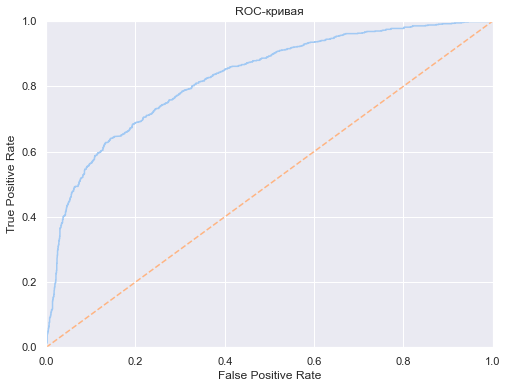

F1: 0.627
ROC_auc: 0.729
Precision: 0.739
Recall: 0.545


In [65]:
results(model_lgbm_class_bow, X_test_bow, y_test_class)

In [66]:
%%time
#LightGBM with TF-IDF
model_lgbm_class_tfidf = model_lgbm.fit(X_train_tfidf, y_train_class)

prediction_lgbm_class_tfidf = model_lgbm_class_tfidf.predict(X_test_tfidf)

f1_lgbm_tfidf_cv = model_lgbm_class_tfidf.best_score_

print('F1 best CV: ', f1_lgbm_tfidf_cv)
print('Best params: ', model_lgbm_class_tfidf.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ....max_depth=10, n_estimators=500;, score=0.587 total time=   2.5s
[CV 2/5] END ....max_depth=10, n_estimators=500;, score=0.630 total time=   2.3s
[CV 3/5] END ....max_depth=10, n_estimators=500;, score=0.617 total time=   2.6s
[CV 4/5] END ....max_depth=10, n_estimators=500;, score=0.607 total time=   2.4s
[CV 5/5] END ....max_depth=10, n_estimators=500;, score=0.618 total time=   2.6s
[CV 1/5] END ...max_depth=10, n_estimators=1000;, score=0.590 total time=   4.8s
[CV 2/5] END ...max_depth=10, n_estimators=1000;, score=0.633 total time=   4.5s
[CV 3/5] END ...max_depth=10, n_estimators=1000;, score=0.614 total time=   4.4s
[CV 4/5] END ...max_depth=10, n_estimators=1000;, score=0.593 total time=   4.9s
[CV 5/5] END ...max_depth=10, n_estimators=1000;, score=0.621 total time=   4.8s
[CV 1/5] END ....max_depth=13, n_estimators=500;, score=0.589 total time=   3.2s
[CV 2/5] END ....max_depth=13, n_estimators=500;,

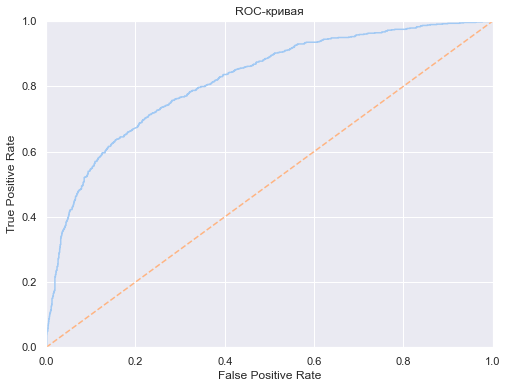

F1: 0.618
ROC_auc: 0.724
Precision: 0.713
Recall: 0.546


In [67]:
results(model_lgbm_class_tfidf, X_test_tfidf, y_test_class)

### Random Forest

In [68]:
%%time
def objective(trial):
    params = {
    'criterion' : trial.suggest_categorical('criterion', ['entropy']),
    'n_estimators' : trial.suggest_int('n_estimators', 1, 100),
    'max_depth' : trial.suggest_int('max_depth', 1, 15),
    'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 2, 20, 2)
    }
    
    model_rf_class = RandomForestClassifier(random_state=RANDOM_STATE)
    model_rf_class = model_rf_class.set_params(**params)
    model_rf_class.fit(X_train_bow, y_train_class)
    
    trial.set_user_attr(key="best_booster", value=model_rf_class)
    cross_valid = cross_val_score(model_rf_class, X_train_bow, y_train_class, cv=5,
                                  scoring='f1', n_jobs=-1).mean()
    return cross_valid
def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])
study1 = optuna.create_study(direction='maximize', sampler=sampler)
study1.optimize(objective, n_trials=100, callbacks=[callback])
model_rf_class = study1.user_attrs["best_booster"]
print('F1:', study1.best_value, 'с параметрами:', study1.best_params)

[I 2023-03-14 19:43:29,779] A new study created in memory with name: no-name-6e713861-273e-4ab8-85c1-eb11cf814efd
[I 2023-03-14 19:43:31,791] Trial 0 finished with value: 0.007929515418502203 and parameters: {'criterion': 'entropy', 'n_estimators': 61, 'max_depth': 3, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.007929515418502203.
[I 2023-03-14 19:43:33,428] Trial 1 finished with value: 0.4883775515321731 and parameters: {'criterion': 'entropy', 'n_estimators': 95, 'max_depth': 15, 'min_samples_leaf': 18}. Best is trial 1 with value: 0.4883775515321731.
[I 2023-03-14 19:43:34,304] Trial 2 finished with value: 0.0 and parameters: {'criterion': 'entropy', 'n_estimators': 31, 'max_depth': 2, 'min_samples_leaf': 14}. Best is trial 1 with value: 0.4883775515321731.
[I 2023-03-14 19:43:35,185] Trial 3 finished with value: 0.0 and parameters: {'criterion': 'entropy', 'n_estimators': 45, 'max_depth': 2, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.4883775515321731.
[I 2023-

[I 2023-03-14 19:43:57,933] Trial 34 finished with value: 0.47916152047708527 and parameters: {'criterion': 'entropy', 'n_estimators': 97, 'max_depth': 13, 'min_samples_leaf': 16}. Best is trial 22 with value: 0.4965017593005173.
[I 2023-03-14 19:43:58,794] Trial 35 finished with value: 0.49417071402922585 and parameters: {'criterion': 'entropy', 'n_estimators': 65, 'max_depth': 15, 'min_samples_leaf': 14}. Best is trial 22 with value: 0.4965017593005173.
[I 2023-03-14 19:43:59,381] Trial 36 finished with value: 0.483340458206768 and parameters: {'criterion': 'entropy', 'n_estimators': 48, 'max_depth': 14, 'min_samples_leaf': 14}. Best is trial 22 with value: 0.4965017593005173.
[I 2023-03-14 19:44:00,118] Trial 37 finished with value: 0.48776755978904723 and parameters: {'criterion': 'entropy', 'n_estimators': 64, 'max_depth': 13, 'min_samples_leaf': 10}. Best is trial 22 with value: 0.4965017593005173.
[I 2023-03-14 19:44:00,657] Trial 38 finished with value: 0.4841460122374607 and p

[I 2023-03-14 19:44:26,486] Trial 68 finished with value: 0.49665837659087736 and parameters: {'criterion': 'entropy', 'n_estimators': 75, 'max_depth': 15, 'min_samples_leaf': 6}. Best is trial 68 with value: 0.49665837659087736.
[I 2023-03-14 19:44:27,667] Trial 69 finished with value: 0.4980901022920099 and parameters: {'criterion': 'entropy', 'n_estimators': 74, 'max_depth': 15, 'min_samples_leaf': 4}. Best is trial 69 with value: 0.4980901022920099.
[I 2023-03-14 19:44:28,483] Trial 70 finished with value: 0.49715892089295766 and parameters: {'criterion': 'entropy', 'n_estimators': 51, 'max_depth': 15, 'min_samples_leaf': 4}. Best is trial 69 with value: 0.4980901022920099.
[I 2023-03-14 19:44:29,374] Trial 71 finished with value: 0.4965057388626171 and parameters: {'criterion': 'entropy', 'n_estimators': 52, 'max_depth': 15, 'min_samples_leaf': 4}. Best is trial 69 with value: 0.4980901022920099.
[I 2023-03-14 19:44:30,255] Trial 72 finished with value: 0.49715892089295766 and par

F1: 0.4980901022920099 с параметрами: {'criterion': 'entropy', 'n_estimators': 74, 'max_depth': 15, 'min_samples_leaf': 4}
CPU times: total: 33.6 s
Wall time: 1min 20s


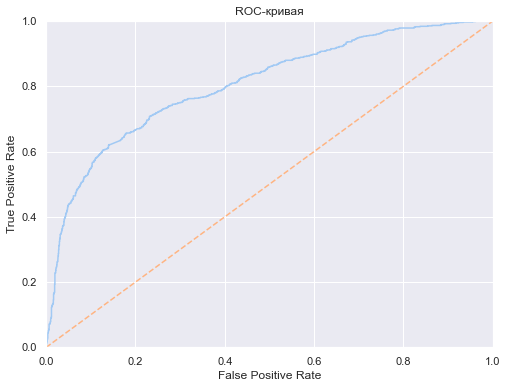

F1: 0.502
ROC_auc: 0.663
Precision: 0.82
Recall: 0.361


In [69]:
results(model_rf_class, X_test_bow, y_test_class)

### CatBoost

In [70]:
#CatBoost model
params = {
    'max_depth' : [10],
    'n_estimators' : [1000]
}
model_catboost = CatBoostClassifier(random_state=RANDOM_STATE)
model_catboost = GridSearchCV(model_catboost, params, scoring='f1', verbose=4)

In [71]:
%%time
#CatBoost with BOW
model_catboost_class_bow = model_catboost.fit(X_train_bow, y_train_class)

prediction_catboost_class_bow = model_catboost_class_bow.predict(X_test_bow)

f1_catboost_bow_cv = model_catboost_class_bow.best_score_

print('F1 best CV: ', f1_catboost_bow_cv)
print('Best params: ', model_catboost_class_bow.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Learning rate set to 0.021948
0:	learn: 0.6853369	total: 82ms	remaining: 1m 21s
1:	learn: 0.6774860	total: 159ms	remaining: 1m 19s
2:	learn: 0.6699612	total: 236ms	remaining: 1m 18s
3:	learn: 0.6628147	total: 308ms	remaining: 1m 16s
4:	learn: 0.6560086	total: 377ms	remaining: 1m 15s
5:	learn: 0.6495589	total: 448ms	remaining: 1m 14s
6:	learn: 0.6433319	total: 515ms	remaining: 1m 13s
7:	learn: 0.6374927	total: 584ms	remaining: 1m 12s
8:	learn: 0.6317826	total: 655ms	remaining: 1m 12s
9:	learn: 0.6260299	total: 724ms	remaining: 1m 11s
10:	learn: 0.6202275	total: 793ms	remaining: 1m 11s
11:	learn: 0.6147126	total: 858ms	remaining: 1m 10s
12:	learn: 0.6100002	total: 928ms	remaining: 1m 10s
13:	learn: 0.6055695	total: 993ms	remaining: 1m 9s
14:	learn: 0.6012265	total: 1.06s	remaining: 1m 9s
15:	learn: 0.5970564	total: 1.13s	remaining: 1m 9s
16:	learn: 0.5928567	total: 1.19s	remaining: 1m 9s
17:	learn: 0.5891869	total: 1.26s	remainin

161:	learn: 0.4529570	total: 11.6s	remaining: 1m
162:	learn: 0.4526328	total: 11.7s	remaining: 1m
163:	learn: 0.4524585	total: 11.8s	remaining: 59.9s
164:	learn: 0.4520254	total: 11.8s	remaining: 59.8s
165:	learn: 0.4518140	total: 11.9s	remaining: 59.8s
166:	learn: 0.4514284	total: 12s	remaining: 59.7s
167:	learn: 0.4510877	total: 12s	remaining: 59.6s
168:	learn: 0.4506744	total: 12.1s	remaining: 59.5s
169:	learn: 0.4503226	total: 12.2s	remaining: 59.4s
170:	learn: 0.4501183	total: 12.2s	remaining: 59.3s
171:	learn: 0.4498901	total: 12.3s	remaining: 59.2s
172:	learn: 0.4495776	total: 12.4s	remaining: 59.1s
173:	learn: 0.4493007	total: 12.4s	remaining: 59.1s
174:	learn: 0.4490794	total: 12.5s	remaining: 59s
175:	learn: 0.4488657	total: 12.6s	remaining: 58.9s
176:	learn: 0.4487123	total: 12.7s	remaining: 58.8s
177:	learn: 0.4485853	total: 12.7s	remaining: 58.8s
178:	learn: 0.4482284	total: 12.8s	remaining: 58.7s
179:	learn: 0.4479978	total: 12.9s	remaining: 58.6s
180:	learn: 0.4477915	to

322:	learn: 0.4204050	total: 23.2s	remaining: 48.6s
323:	learn: 0.4202390	total: 23.3s	remaining: 48.6s
324:	learn: 0.4201115	total: 23.3s	remaining: 48.5s
325:	learn: 0.4200033	total: 23.4s	remaining: 48.4s
326:	learn: 0.4198404	total: 23.5s	remaining: 48.3s
327:	learn: 0.4196812	total: 23.6s	remaining: 48.3s
328:	learn: 0.4195260	total: 23.6s	remaining: 48.2s
329:	learn: 0.4193780	total: 23.7s	remaining: 48.2s
330:	learn: 0.4192568	total: 23.8s	remaining: 48.1s
331:	learn: 0.4190350	total: 23.9s	remaining: 48.1s
332:	learn: 0.4188940	total: 24s	remaining: 48s
333:	learn: 0.4184230	total: 24s	remaining: 47.9s
334:	learn: 0.4183255	total: 24.1s	remaining: 47.8s
335:	learn: 0.4181988	total: 24.2s	remaining: 47.8s
336:	learn: 0.4180520	total: 24.3s	remaining: 47.7s
337:	learn: 0.4179365	total: 24.3s	remaining: 47.7s
338:	learn: 0.4177538	total: 24.4s	remaining: 47.6s
339:	learn: 0.4176040	total: 24.5s	remaining: 47.5s
340:	learn: 0.4174001	total: 24.6s	remaining: 47.4s
341:	learn: 0.4173

482:	learn: 0.3816843	total: 34.8s	remaining: 37.3s
483:	learn: 0.3814861	total: 34.9s	remaining: 37.2s
484:	learn: 0.3813834	total: 35s	remaining: 37.2s
485:	learn: 0.3810189	total: 35.1s	remaining: 37.1s
486:	learn: 0.3808864	total: 35.1s	remaining: 37s
487:	learn: 0.3806379	total: 35.2s	remaining: 36.9s
488:	learn: 0.3805293	total: 35.3s	remaining: 36.9s
489:	learn: 0.3804242	total: 35.4s	remaining: 36.8s
490:	learn: 0.3803198	total: 35.4s	remaining: 36.7s
491:	learn: 0.3802171	total: 35.5s	remaining: 36.7s
492:	learn: 0.3800811	total: 35.6s	remaining: 36.6s
493:	learn: 0.3795940	total: 35.7s	remaining: 36.5s
494:	learn: 0.3791778	total: 35.8s	remaining: 36.5s
495:	learn: 0.3790786	total: 35.8s	remaining: 36.4s
496:	learn: 0.3788751	total: 35.9s	remaining: 36.3s
497:	learn: 0.3784556	total: 36s	remaining: 36.3s
498:	learn: 0.3782635	total: 36.1s	remaining: 36.2s
499:	learn: 0.3779753	total: 36.1s	remaining: 36.1s
500:	learn: 0.3776470	total: 36.2s	remaining: 36s
501:	learn: 0.377302

643:	learn: 0.3460155	total: 46.6s	remaining: 25.7s
644:	learn: 0.3458019	total: 46.6s	remaining: 25.7s
645:	learn: 0.3457392	total: 46.7s	remaining: 25.6s
646:	learn: 0.3454950	total: 46.8s	remaining: 25.5s
647:	learn: 0.3453490	total: 46.9s	remaining: 25.4s
648:	learn: 0.3449234	total: 46.9s	remaining: 25.4s
649:	learn: 0.3444853	total: 47s	remaining: 25.3s
650:	learn: 0.3441435	total: 47.1s	remaining: 25.2s
651:	learn: 0.3439675	total: 47.1s	remaining: 25.2s
652:	learn: 0.3435764	total: 47.2s	remaining: 25.1s
653:	learn: 0.3432994	total: 47.3s	remaining: 25s
654:	learn: 0.3429734	total: 47.3s	remaining: 24.9s
655:	learn: 0.3427119	total: 47.4s	remaining: 24.9s
656:	learn: 0.3426439	total: 47.5s	remaining: 24.8s
657:	learn: 0.3423835	total: 47.5s	remaining: 24.7s
658:	learn: 0.3420869	total: 47.6s	remaining: 24.6s
659:	learn: 0.3418887	total: 47.7s	remaining: 24.6s
660:	learn: 0.3416577	total: 47.7s	remaining: 24.5s
661:	learn: 0.3415072	total: 47.8s	remaining: 24.4s
662:	learn: 0.34

805:	learn: 0.3138570	total: 58.3s	remaining: 14s
806:	learn: 0.3137833	total: 58.4s	remaining: 14s
807:	learn: 0.3135862	total: 58.5s	remaining: 13.9s
808:	learn: 0.3134420	total: 58.5s	remaining: 13.8s
809:	learn: 0.3132482	total: 58.6s	remaining: 13.7s
810:	learn: 0.3130588	total: 58.7s	remaining: 13.7s
811:	learn: 0.3129304	total: 58.7s	remaining: 13.6s
812:	learn: 0.3127687	total: 58.8s	remaining: 13.5s
813:	learn: 0.3123735	total: 58.9s	remaining: 13.5s
814:	learn: 0.3121716	total: 58.9s	remaining: 13.4s
815:	learn: 0.3121332	total: 59s	remaining: 13.3s
816:	learn: 0.3120909	total: 59.1s	remaining: 13.2s
817:	learn: 0.3116809	total: 59.1s	remaining: 13.2s
818:	learn: 0.3114528	total: 59.2s	remaining: 13.1s
819:	learn: 0.3112547	total: 59.3s	remaining: 13s
820:	learn: 0.3112185	total: 59.3s	remaining: 12.9s
821:	learn: 0.3109534	total: 59.4s	remaining: 12.9s
822:	learn: 0.3108862	total: 59.5s	remaining: 12.8s
823:	learn: 0.3107230	total: 59.5s	remaining: 12.7s
824:	learn: 0.310616

964:	learn: 0.2923812	total: 1m 9s	remaining: 2.53s
965:	learn: 0.2922712	total: 1m 9s	remaining: 2.46s
966:	learn: 0.2922449	total: 1m 9s	remaining: 2.39s
967:	learn: 0.2921148	total: 1m 9s	remaining: 2.31s
968:	learn: 0.2920915	total: 1m 10s	remaining: 2.24s
969:	learn: 0.2919290	total: 1m 10s	remaining: 2.17s
970:	learn: 0.2918877	total: 1m 10s	remaining: 2.1s
971:	learn: 0.2915974	total: 1m 10s	remaining: 2.02s
972:	learn: 0.2915643	total: 1m 10s	remaining: 1.95s
973:	learn: 0.2915333	total: 1m 10s	remaining: 1.88s
974:	learn: 0.2915059	total: 1m 10s	remaining: 1.81s
975:	learn: 0.2914665	total: 1m 10s	remaining: 1.74s
976:	learn: 0.2912927	total: 1m 10s	remaining: 1.66s
977:	learn: 0.2910746	total: 1m 10s	remaining: 1.59s
978:	learn: 0.2909348	total: 1m 10s	remaining: 1.52s
979:	learn: 0.2909069	total: 1m 10s	remaining: 1.45s
980:	learn: 0.2907851	total: 1m 10s	remaining: 1.37s
981:	learn: 0.2905946	total: 1m 11s	remaining: 1.3s
982:	learn: 0.2905667	total: 1m 11s	remaining: 1.23s

120:	learn: 0.4697717	total: 11.2s	remaining: 1m 21s
121:	learn: 0.4695736	total: 11.3s	remaining: 1m 21s
122:	learn: 0.4693315	total: 11.4s	remaining: 1m 21s
123:	learn: 0.4691322	total: 11.5s	remaining: 1m 21s
124:	learn: 0.4684362	total: 11.6s	remaining: 1m 21s
125:	learn: 0.4680542	total: 11.7s	remaining: 1m 21s
126:	learn: 0.4677757	total: 11.8s	remaining: 1m 20s
127:	learn: 0.4669162	total: 11.9s	remaining: 1m 20s
128:	learn: 0.4665256	total: 12s	remaining: 1m 20s
129:	learn: 0.4661546	total: 12.1s	remaining: 1m 20s
130:	learn: 0.4657967	total: 12.2s	remaining: 1m 20s
131:	learn: 0.4654730	total: 12.2s	remaining: 1m 20s
132:	learn: 0.4649859	total: 12.3s	remaining: 1m 20s
133:	learn: 0.4644595	total: 12.4s	remaining: 1m 20s
134:	learn: 0.4642462	total: 12.5s	remaining: 1m 20s
135:	learn: 0.4639316	total: 12.6s	remaining: 1m 20s
136:	learn: 0.4635953	total: 12.7s	remaining: 1m 20s
137:	learn: 0.4632461	total: 12.8s	remaining: 1m 19s
138:	learn: 0.4629396	total: 12.9s	remaining: 1m

276:	learn: 0.4294870	total: 25.8s	remaining: 1m 7s
277:	learn: 0.4293751	total: 25.9s	remaining: 1m 7s
278:	learn: 0.4290695	total: 26s	remaining: 1m 7s
279:	learn: 0.4289760	total: 26.1s	remaining: 1m 7s
280:	learn: 0.4288743	total: 26.2s	remaining: 1m 7s
281:	learn: 0.4287201	total: 26.3s	remaining: 1m 6s
282:	learn: 0.4286088	total: 26.4s	remaining: 1m 6s
283:	learn: 0.4283590	total: 26.5s	remaining: 1m 6s
284:	learn: 0.4281417	total: 26.6s	remaining: 1m 6s
285:	learn: 0.4280016	total: 26.7s	remaining: 1m 6s
286:	learn: 0.4279188	total: 26.8s	remaining: 1m 6s
287:	learn: 0.4277737	total: 26.9s	remaining: 1m 6s
288:	learn: 0.4275977	total: 27s	remaining: 1m 6s
289:	learn: 0.4275322	total: 27.1s	remaining: 1m 6s
290:	learn: 0.4273729	total: 27.2s	remaining: 1m 6s
291:	learn: 0.4272600	total: 27.3s	remaining: 1m 6s
292:	learn: 0.4270845	total: 27.4s	remaining: 1m 6s
293:	learn: 0.4268948	total: 27.5s	remaining: 1m 5s
294:	learn: 0.4267769	total: 27.6s	remaining: 1m 5s
295:	learn: 0.42

438:	learn: 0.3970516	total: 41s	remaining: 52.4s
439:	learn: 0.3967699	total: 41.1s	remaining: 52.3s
440:	learn: 0.3966418	total: 41.2s	remaining: 52.3s
441:	learn: 0.3960514	total: 41.3s	remaining: 52.2s
442:	learn: 0.3959260	total: 41.4s	remaining: 52.1s
443:	learn: 0.3957924	total: 41.5s	remaining: 52s
444:	learn: 0.3956820	total: 41.6s	remaining: 51.9s
445:	learn: 0.3954987	total: 41.7s	remaining: 51.8s
446:	learn: 0.3949643	total: 41.8s	remaining: 51.7s
447:	learn: 0.3947796	total: 41.9s	remaining: 51.7s
448:	learn: 0.3946093	total: 42s	remaining: 51.6s
449:	learn: 0.3943464	total: 42.1s	remaining: 51.5s
450:	learn: 0.3938259	total: 42.2s	remaining: 51.4s
451:	learn: 0.3936403	total: 42.3s	remaining: 51.3s
452:	learn: 0.3935298	total: 42.4s	remaining: 51.2s
453:	learn: 0.3928526	total: 42.5s	remaining: 51.1s
454:	learn: 0.3927292	total: 42.6s	remaining: 51s
455:	learn: 0.3926209	total: 42.7s	remaining: 50.9s
456:	learn: 0.3921154	total: 42.8s	remaining: 50.8s
457:	learn: 0.392007

597:	learn: 0.3561432	total: 56s	remaining: 37.7s
598:	learn: 0.3560648	total: 56.1s	remaining: 37.6s
599:	learn: 0.3555581	total: 56.2s	remaining: 37.5s
600:	learn: 0.3554670	total: 56.3s	remaining: 37.4s
601:	learn: 0.3552561	total: 56.4s	remaining: 37.3s
602:	learn: 0.3548636	total: 56.5s	remaining: 37.2s
603:	learn: 0.3547765	total: 56.6s	remaining: 37.1s
604:	learn: 0.3546763	total: 56.7s	remaining: 37s
605:	learn: 0.3546024	total: 56.8s	remaining: 36.9s
606:	learn: 0.3545341	total: 56.9s	remaining: 36.8s
607:	learn: 0.3544429	total: 56.9s	remaining: 36.7s
608:	learn: 0.3540730	total: 57s	remaining: 36.6s
609:	learn: 0.3538227	total: 57.1s	remaining: 36.5s
610:	learn: 0.3535526	total: 57.2s	remaining: 36.4s
611:	learn: 0.3534138	total: 57.3s	remaining: 36.3s
612:	learn: 0.3530409	total: 57.4s	remaining: 36.3s
613:	learn: 0.3526893	total: 57.5s	remaining: 36.2s
614:	learn: 0.3525103	total: 57.6s	remaining: 36.1s
615:	learn: 0.3524308	total: 57.7s	remaining: 36s
616:	learn: 0.352298

758:	learn: 0.3259151	total: 1m 11s	remaining: 22.7s
759:	learn: 0.3258493	total: 1m 11s	remaining: 22.6s
760:	learn: 0.3256350	total: 1m 11s	remaining: 22.5s
761:	learn: 0.3255935	total: 1m 11s	remaining: 22.4s
762:	learn: 0.3251795	total: 1m 11s	remaining: 22.3s
763:	learn: 0.3248730	total: 1m 11s	remaining: 22.2s
764:	learn: 0.3247392	total: 1m 11s	remaining: 22.1s
765:	learn: 0.3246192	total: 1m 12s	remaining: 22s
766:	learn: 0.3243538	total: 1m 12s	remaining: 21.9s
767:	learn: 0.3239777	total: 1m 12s	remaining: 21.8s
768:	learn: 0.3237239	total: 1m 12s	remaining: 21.7s
769:	learn: 0.3235982	total: 1m 12s	remaining: 21.6s
770:	learn: 0.3234227	total: 1m 12s	remaining: 21.5s
771:	learn: 0.3233779	total: 1m 12s	remaining: 21.4s
772:	learn: 0.3233168	total: 1m 12s	remaining: 21.3s
773:	learn: 0.3231497	total: 1m 12s	remaining: 21.2s
774:	learn: 0.3230818	total: 1m 12s	remaining: 21.1s
775:	learn: 0.3227980	total: 1m 12s	remaining: 21.1s
776:	learn: 0.3227304	total: 1m 13s	remaining: 2

914:	learn: 0.3014893	total: 1m 26s	remaining: 8.01s
915:	learn: 0.3014373	total: 1m 26s	remaining: 7.91s
916:	learn: 0.3011785	total: 1m 26s	remaining: 7.82s
917:	learn: 0.3011380	total: 1m 26s	remaining: 7.72s
918:	learn: 0.3009271	total: 1m 26s	remaining: 7.63s
919:	learn: 0.3007645	total: 1m 26s	remaining: 7.54s
920:	learn: 0.3006641	total: 1m 26s	remaining: 7.44s
921:	learn: 0.3003453	total: 1m 26s	remaining: 7.35s
922:	learn: 0.3003133	total: 1m 26s	remaining: 7.26s
923:	learn: 0.3000587	total: 1m 27s	remaining: 7.16s
924:	learn: 0.2999433	total: 1m 27s	remaining: 7.07s
925:	learn: 0.2999025	total: 1m 27s	remaining: 6.97s
926:	learn: 0.2996440	total: 1m 27s	remaining: 6.88s
927:	learn: 0.2995932	total: 1m 27s	remaining: 6.79s
928:	learn: 0.2995476	total: 1m 27s	remaining: 6.69s
929:	learn: 0.2995120	total: 1m 27s	remaining: 6.6s
930:	learn: 0.2992708	total: 1m 27s	remaining: 6.51s
931:	learn: 0.2992162	total: 1m 27s	remaining: 6.41s
932:	learn: 0.2990816	total: 1m 27s	remaining: 

71:	learn: 0.4976263	total: 7.45s	remaining: 1m 35s
72:	learn: 0.4968267	total: 7.54s	remaining: 1m 35s
73:	learn: 0.4963166	total: 7.64s	remaining: 1m 35s
74:	learn: 0.4954060	total: 7.74s	remaining: 1m 35s
75:	learn: 0.4943288	total: 7.84s	remaining: 1m 35s
76:	learn: 0.4929632	total: 7.94s	remaining: 1m 35s
77:	learn: 0.4919841	total: 8.05s	remaining: 1m 35s
78:	learn: 0.4909731	total: 8.16s	remaining: 1m 35s
79:	learn: 0.4901146	total: 8.27s	remaining: 1m 35s
80:	learn: 0.4895988	total: 8.38s	remaining: 1m 35s
81:	learn: 0.4889492	total: 8.48s	remaining: 1m 34s
82:	learn: 0.4884295	total: 8.59s	remaining: 1m 34s
83:	learn: 0.4878339	total: 8.7s	remaining: 1m 34s
84:	learn: 0.4873870	total: 8.8s	remaining: 1m 34s
85:	learn: 0.4867956	total: 8.91s	remaining: 1m 34s
86:	learn: 0.4861823	total: 8.93s	remaining: 1m 33s
87:	learn: 0.4853681	total: 9.04s	remaining: 1m 33s
88:	learn: 0.4846778	total: 9.15s	remaining: 1m 33s
89:	learn: 0.4840177	total: 9.26s	remaining: 1m 33s
90:	learn: 0.4

228:	learn: 0.4390215	total: 23.6s	remaining: 1m 19s
229:	learn: 0.4387985	total: 23.7s	remaining: 1m 19s
230:	learn: 0.4385903	total: 23.8s	remaining: 1m 19s
231:	learn: 0.4383767	total: 23.9s	remaining: 1m 19s
232:	learn: 0.4382446	total: 24s	remaining: 1m 19s
233:	learn: 0.4381502	total: 24.1s	remaining: 1m 18s
234:	learn: 0.4379295	total: 24.2s	remaining: 1m 18s
235:	learn: 0.4377043	total: 24.3s	remaining: 1m 18s
236:	learn: 0.4373733	total: 24.4s	remaining: 1m 18s
237:	learn: 0.4372386	total: 24.5s	remaining: 1m 18s
238:	learn: 0.4371213	total: 24.6s	remaining: 1m 18s
239:	learn: 0.4370099	total: 24.8s	remaining: 1m 18s
240:	learn: 0.4368006	total: 24.9s	remaining: 1m 18s
241:	learn: 0.4366344	total: 25s	remaining: 1m 18s
242:	learn: 0.4364546	total: 25.1s	remaining: 1m 18s
243:	learn: 0.4361086	total: 25.2s	remaining: 1m 17s
244:	learn: 0.4360275	total: 25.3s	remaining: 1m 17s
245:	learn: 0.4357677	total: 25.4s	remaining: 1m 17s
246:	learn: 0.4355522	total: 25.4s	remaining: 1m 1

387:	learn: 0.4079700	total: 40s	remaining: 1m 3s
388:	learn: 0.4077142	total: 40.1s	remaining: 1m 2s
389:	learn: 0.4073612	total: 40.2s	remaining: 1m 2s
390:	learn: 0.4072221	total: 40.3s	remaining: 1m 2s
391:	learn: 0.4069914	total: 40.4s	remaining: 1m 2s
392:	learn: 0.4069263	total: 40.5s	remaining: 1m 2s
393:	learn: 0.4066915	total: 40.6s	remaining: 1m 2s
394:	learn: 0.4064103	total: 40.7s	remaining: 1m 2s
395:	learn: 0.4062395	total: 40.8s	remaining: 1m 2s
396:	learn: 0.4060607	total: 40.9s	remaining: 1m 2s
397:	learn: 0.4056747	total: 41s	remaining: 1m 1s
398:	learn: 0.4053452	total: 41.1s	remaining: 1m 1s
399:	learn: 0.4050054	total: 41.2s	remaining: 1m 1s
400:	learn: 0.4049018	total: 41.3s	remaining: 1m 1s
401:	learn: 0.4045642	total: 41.4s	remaining: 1m 1s
402:	learn: 0.4044303	total: 41.5s	remaining: 1m 1s
403:	learn: 0.4041461	total: 41.5s	remaining: 1m 1s
404:	learn: 0.4032963	total: 41.7s	remaining: 1m 1s
405:	learn: 0.4031115	total: 41.8s	remaining: 1m 1s
406:	learn: 0.40

549:	learn: 0.3667101	total: 56.6s	remaining: 46.3s
550:	learn: 0.3665577	total: 56.7s	remaining: 46.2s
551:	learn: 0.3664869	total: 56.8s	remaining: 46.1s
552:	learn: 0.3663985	total: 56.9s	remaining: 46s
553:	learn: 0.3659065	total: 57s	remaining: 45.9s
554:	learn: 0.3656838	total: 57.1s	remaining: 45.8s
555:	learn: 0.3655897	total: 57.2s	remaining: 45.7s
556:	learn: 0.3652113	total: 57.3s	remaining: 45.6s
557:	learn: 0.3651477	total: 57.4s	remaining: 45.5s
558:	learn: 0.3650128	total: 57.5s	remaining: 45.4s
559:	learn: 0.3645750	total: 57.6s	remaining: 45.3s
560:	learn: 0.3644079	total: 57.8s	remaining: 45.2s
561:	learn: 0.3643102	total: 57.9s	remaining: 45.1s
562:	learn: 0.3640205	total: 58s	remaining: 45s
563:	learn: 0.3635230	total: 58.1s	remaining: 44.9s
564:	learn: 0.3633518	total: 58.2s	remaining: 44.8s
565:	learn: 0.3630877	total: 58.3s	remaining: 44.7s
566:	learn: 0.3627772	total: 58.4s	remaining: 44.6s
567:	learn: 0.3625021	total: 58.5s	remaining: 44.5s
568:	learn: 0.362381

709:	learn: 0.3337069	total: 1m 12s	remaining: 29.8s
710:	learn: 0.3334679	total: 1m 13s	remaining: 29.7s
711:	learn: 0.3332068	total: 1m 13s	remaining: 29.6s
712:	learn: 0.3331631	total: 1m 13s	remaining: 29.5s
713:	learn: 0.3330383	total: 1m 13s	remaining: 29.4s
714:	learn: 0.3329726	total: 1m 13s	remaining: 29.3s
715:	learn: 0.3329188	total: 1m 13s	remaining: 29.2s
716:	learn: 0.3326769	total: 1m 13s	remaining: 29.1s
717:	learn: 0.3326007	total: 1m 13s	remaining: 29s
718:	learn: 0.3322636	total: 1m 13s	remaining: 28.9s
719:	learn: 0.3319179	total: 1m 14s	remaining: 28.8s
720:	learn: 0.3318229	total: 1m 14s	remaining: 28.7s
721:	learn: 0.3317644	total: 1m 14s	remaining: 28.6s
722:	learn: 0.3316869	total: 1m 14s	remaining: 28.5s
723:	learn: 0.3314976	total: 1m 14s	remaining: 28.4s
724:	learn: 0.3313617	total: 1m 14s	remaining: 28.3s
725:	learn: 0.3312617	total: 1m 14s	remaining: 28.2s
726:	learn: 0.3311770	total: 1m 14s	remaining: 28.1s
727:	learn: 0.3310621	total: 1m 14s	remaining: 2

866:	learn: 0.3098048	total: 1m 29s	remaining: 13.7s
867:	learn: 0.3094450	total: 1m 29s	remaining: 13.6s
868:	learn: 0.3093059	total: 1m 29s	remaining: 13.5s
869:	learn: 0.3088892	total: 1m 29s	remaining: 13.4s
870:	learn: 0.3086601	total: 1m 29s	remaining: 13.3s
871:	learn: 0.3083711	total: 1m 29s	remaining: 13.2s
872:	learn: 0.3083250	total: 1m 29s	remaining: 13.1s
873:	learn: 0.3081893	total: 1m 29s	remaining: 13s
874:	learn: 0.3081074	total: 1m 29s	remaining: 12.9s
875:	learn: 0.3078970	total: 1m 30s	remaining: 12.7s
876:	learn: 0.3078428	total: 1m 30s	remaining: 12.6s
877:	learn: 0.3076967	total: 1m 30s	remaining: 12.5s
878:	learn: 0.3074524	total: 1m 30s	remaining: 12.4s
879:	learn: 0.3074170	total: 1m 30s	remaining: 12.3s
880:	learn: 0.3073700	total: 1m 30s	remaining: 12.2s
881:	learn: 0.3069928	total: 1m 30s	remaining: 12.1s
882:	learn: 0.3067632	total: 1m 30s	remaining: 12s
883:	learn: 0.3066525	total: 1m 30s	remaining: 11.9s
884:	learn: 0.3066002	total: 1m 30s	remaining: 11.

21:	learn: 0.5782313	total: 2.49s	remaining: 1m 50s
22:	learn: 0.5752029	total: 2.6s	remaining: 1m 50s
23:	learn: 0.5721856	total: 2.71s	remaining: 1m 50s
24:	learn: 0.5692716	total: 2.82s	remaining: 1m 49s
25:	learn: 0.5667730	total: 2.92s	remaining: 1m 49s
26:	learn: 0.5641089	total: 3.03s	remaining: 1m 49s
27:	learn: 0.5617790	total: 3.14s	remaining: 1m 49s
28:	learn: 0.5592453	total: 3.25s	remaining: 1m 48s
29:	learn: 0.5571517	total: 3.35s	remaining: 1m 48s
30:	learn: 0.5547398	total: 3.46s	remaining: 1m 48s
31:	learn: 0.5524665	total: 3.56s	remaining: 1m 47s
32:	learn: 0.5506691	total: 3.67s	remaining: 1m 47s
33:	learn: 0.5470426	total: 3.78s	remaining: 1m 47s
34:	learn: 0.5454956	total: 3.89s	remaining: 1m 47s
35:	learn: 0.5434061	total: 3.99s	remaining: 1m 46s
36:	learn: 0.5415756	total: 4.1s	remaining: 1m 46s
37:	learn: 0.5399958	total: 4.21s	remaining: 1m 46s
38:	learn: 0.5380309	total: 4.31s	remaining: 1m 46s
39:	learn: 0.5367550	total: 4.42s	remaining: 1m 46s
40:	learn: 0.5

179:	learn: 0.4491964	total: 20.1s	remaining: 1m 31s
180:	learn: 0.4490220	total: 20.3s	remaining: 1m 31s
181:	learn: 0.4488924	total: 20.4s	remaining: 1m 31s
182:	learn: 0.4485853	total: 20.5s	remaining: 1m 31s
183:	learn: 0.4483828	total: 20.6s	remaining: 1m 31s
184:	learn: 0.4482485	total: 20.7s	remaining: 1m 31s
185:	learn: 0.4480294	total: 20.8s	remaining: 1m 30s
186:	learn: 0.4476216	total: 20.9s	remaining: 1m 30s
187:	learn: 0.4473567	total: 21s	remaining: 1m 30s
188:	learn: 0.4471374	total: 21.1s	remaining: 1m 30s
189:	learn: 0.4470409	total: 21.2s	remaining: 1m 30s
190:	learn: 0.4468807	total: 21.3s	remaining: 1m 30s
191:	learn: 0.4466968	total: 21.5s	remaining: 1m 30s
192:	learn: 0.4464935	total: 21.6s	remaining: 1m 30s
193:	learn: 0.4463347	total: 21.7s	remaining: 1m 30s
194:	learn: 0.4462263	total: 21.8s	remaining: 1m 30s
195:	learn: 0.4461155	total: 21.9s	remaining: 1m 29s
196:	learn: 0.4459460	total: 22.1s	remaining: 1m 29s
197:	learn: 0.4457738	total: 22.2s	remaining: 1m

336:	learn: 0.4183921	total: 38.9s	remaining: 1m 16s
337:	learn: 0.4180650	total: 39s	remaining: 1m 16s
338:	learn: 0.4179657	total: 39.1s	remaining: 1m 16s
339:	learn: 0.4178986	total: 39.2s	remaining: 1m 16s
340:	learn: 0.4178075	total: 39.4s	remaining: 1m 16s
341:	learn: 0.4175091	total: 39.5s	remaining: 1m 15s
342:	learn: 0.4173626	total: 39.6s	remaining: 1m 15s
343:	learn: 0.4172133	total: 39.7s	remaining: 1m 15s
344:	learn: 0.4170494	total: 39.9s	remaining: 1m 15s
345:	learn: 0.4167342	total: 40s	remaining: 1m 15s
346:	learn: 0.4165024	total: 40.1s	remaining: 1m 15s
347:	learn: 0.4160956	total: 40.2s	remaining: 1m 15s
348:	learn: 0.4158918	total: 40.4s	remaining: 1m 15s
349:	learn: 0.4157956	total: 40.5s	remaining: 1m 15s
350:	learn: 0.4155844	total: 40.6s	remaining: 1m 15s
351:	learn: 0.4154042	total: 40.7s	remaining: 1m 15s
352:	learn: 0.4152888	total: 40.9s	remaining: 1m 14s
353:	learn: 0.4151634	total: 41s	remaining: 1m 14s
354:	learn: 0.4150231	total: 41.1s	remaining: 1m 14s

494:	learn: 0.3810786	total: 58.9s	remaining: 1m
495:	learn: 0.3807475	total: 59.1s	remaining: 1m
496:	learn: 0.3805565	total: 59.2s	remaining: 59.9s
497:	learn: 0.3804502	total: 59.3s	remaining: 59.8s
498:	learn: 0.3803300	total: 59.4s	remaining: 59.7s
499:	learn: 0.3800477	total: 59.6s	remaining: 59.6s
500:	learn: 0.3798574	total: 59.7s	remaining: 59.5s
501:	learn: 0.3796614	total: 59.8s	remaining: 59.3s
502:	learn: 0.3794510	total: 59.9s	remaining: 59.2s
503:	learn: 0.3791976	total: 1m	remaining: 59.1s
504:	learn: 0.3791254	total: 1m	remaining: 59s
505:	learn: 0.3790253	total: 1m	remaining: 58.9s
506:	learn: 0.3787238	total: 1m	remaining: 58.8s
507:	learn: 0.3783967	total: 1m	remaining: 58.7s
508:	learn: 0.3780068	total: 1m	remaining: 58.6s
509:	learn: 0.3779170	total: 1m	remaining: 58.4s
510:	learn: 0.3778146	total: 1m	remaining: 58.3s
511:	learn: 0.3777113	total: 1m 1s	remaining: 58.2s
512:	learn: 0.3774566	total: 1m 1s	remaining: 58.1s
513:	learn: 0.3772168	total: 1m 1s	remaining

652:	learn: 0.3456552	total: 1m 18s	remaining: 42s
653:	learn: 0.3455966	total: 1m 19s	remaining: 41.9s
654:	learn: 0.3451044	total: 1m 19s	remaining: 41.7s
655:	learn: 0.3449279	total: 1m 19s	remaining: 41.6s
656:	learn: 0.3446914	total: 1m 19s	remaining: 41.5s
657:	learn: 0.3444413	total: 1m 19s	remaining: 41.4s
658:	learn: 0.3442711	total: 1m 19s	remaining: 41.3s
659:	learn: 0.3439087	total: 1m 19s	remaining: 41.1s
660:	learn: 0.3438210	total: 1m 19s	remaining: 41s
661:	learn: 0.3437468	total: 1m 20s	remaining: 40.9s
662:	learn: 0.3434832	total: 1m 20s	remaining: 40.8s
663:	learn: 0.3433576	total: 1m 20s	remaining: 40.6s
664:	learn: 0.3431248	total: 1m 20s	remaining: 40.5s
665:	learn: 0.3426260	total: 1m 20s	remaining: 40.4s
666:	learn: 0.3425501	total: 1m 20s	remaining: 40.3s
667:	learn: 0.3424624	total: 1m 20s	remaining: 40.2s
668:	learn: 0.3422569	total: 1m 20s	remaining: 40.1s
669:	learn: 0.3420210	total: 1m 21s	remaining: 39.9s
670:	learn: 0.3419141	total: 1m 21s	remaining: 39.

808:	learn: 0.3138500	total: 1m 38s	remaining: 23.3s
809:	learn: 0.3135891	total: 1m 38s	remaining: 23.2s
810:	learn: 0.3134910	total: 1m 39s	remaining: 23.1s
811:	learn: 0.3134487	total: 1m 39s	remaining: 23s
812:	learn: 0.3132183	total: 1m 39s	remaining: 22.8s
813:	learn: 0.3131457	total: 1m 39s	remaining: 22.7s
814:	learn: 0.3130963	total: 1m 39s	remaining: 22.6s
815:	learn: 0.3129368	total: 1m 39s	remaining: 22.5s
816:	learn: 0.3126907	total: 1m 39s	remaining: 22.4s
817:	learn: 0.3125194	total: 1m 39s	remaining: 22.2s
818:	learn: 0.3123600	total: 1m 40s	remaining: 22.1s
819:	learn: 0.3121364	total: 1m 40s	remaining: 22s
820:	learn: 0.3120911	total: 1m 40s	remaining: 21.9s
821:	learn: 0.3120322	total: 1m 40s	remaining: 21.8s
822:	learn: 0.3119885	total: 1m 40s	remaining: 21.6s
823:	learn: 0.3119570	total: 1m 40s	remaining: 21.5s
824:	learn: 0.3118275	total: 1m 40s	remaining: 21.4s
825:	learn: 0.3117376	total: 1m 40s	remaining: 21.3s
826:	learn: 0.3116537	total: 1m 41s	remaining: 21.

964:	learn: 0.2917843	total: 1m 58s	remaining: 4.31s
965:	learn: 0.2916308	total: 1m 58s	remaining: 4.19s
966:	learn: 0.2916019	total: 1m 59s	remaining: 4.06s
967:	learn: 0.2914730	total: 1m 59s	remaining: 3.94s
968:	learn: 0.2912445	total: 1m 59s	remaining: 3.82s
969:	learn: 0.2909697	total: 1m 59s	remaining: 3.69s
970:	learn: 0.2908142	total: 1m 59s	remaining: 3.57s
971:	learn: 0.2906266	total: 1m 59s	remaining: 3.45s
972:	learn: 0.2903208	total: 1m 59s	remaining: 3.33s
973:	learn: 0.2902774	total: 1m 59s	remaining: 3.2s
974:	learn: 0.2901445	total: 2m	remaining: 3.08s
975:	learn: 0.2899198	total: 2m	remaining: 2.96s
976:	learn: 0.2897446	total: 2m	remaining: 2.83s
977:	learn: 0.2895771	total: 2m	remaining: 2.71s
978:	learn: 0.2893914	total: 2m	remaining: 2.59s
979:	learn: 0.2890954	total: 2m	remaining: 2.46s
980:	learn: 0.2889732	total: 2m	remaining: 2.34s
981:	learn: 0.2889433	total: 2m 1s	remaining: 2.22s
982:	learn: 0.2886275	total: 2m 1s	remaining: 2.1s
983:	learn: 0.2885604	tot

122:	learn: 0.4657418	total: 16.6s	remaining: 1m 58s
123:	learn: 0.4656121	total: 16.7s	remaining: 1m 58s
124:	learn: 0.4651684	total: 16.8s	remaining: 1m 57s
125:	learn: 0.4646161	total: 17s	remaining: 1m 57s
126:	learn: 0.4643061	total: 17.1s	remaining: 1m 57s
127:	learn: 0.4641213	total: 17.2s	remaining: 1m 57s
128:	learn: 0.4635134	total: 17.4s	remaining: 1m 57s
129:	learn: 0.4632732	total: 17.5s	remaining: 1m 57s
130:	learn: 0.4629199	total: 17.6s	remaining: 1m 57s
131:	learn: 0.4623825	total: 17.8s	remaining: 1m 56s
132:	learn: 0.4621933	total: 17.9s	remaining: 1m 56s
133:	learn: 0.4614542	total: 18.1s	remaining: 1m 56s
134:	learn: 0.4612778	total: 18.2s	remaining: 1m 56s
135:	learn: 0.4609026	total: 18.3s	remaining: 1m 56s
136:	learn: 0.4601937	total: 18.5s	remaining: 1m 56s
137:	learn: 0.4598140	total: 18.6s	remaining: 1m 56s
138:	learn: 0.4593631	total: 18.7s	remaining: 1m 55s
139:	learn: 0.4589844	total: 18.9s	remaining: 1m 55s
140:	learn: 0.4586560	total: 19s	remaining: 1m 5

278:	learn: 0.4265782	total: 37.4s	remaining: 1m 36s
279:	learn: 0.4264200	total: 37.6s	remaining: 1m 36s
280:	learn: 0.4262496	total: 37.7s	remaining: 1m 36s
281:	learn: 0.4261257	total: 37.8s	remaining: 1m 36s
282:	learn: 0.4259349	total: 37.9s	remaining: 1m 36s
283:	learn: 0.4257786	total: 38s	remaining: 1m 35s
284:	learn: 0.4255235	total: 38.1s	remaining: 1m 35s
285:	learn: 0.4254186	total: 38.3s	remaining: 1m 35s
286:	learn: 0.4252508	total: 38.4s	remaining: 1m 35s
287:	learn: 0.4251304	total: 38.5s	remaining: 1m 35s
288:	learn: 0.4249598	total: 38.6s	remaining: 1m 34s
289:	learn: 0.4248160	total: 38.7s	remaining: 1m 34s
290:	learn: 0.4245044	total: 38.9s	remaining: 1m 34s
291:	learn: 0.4243091	total: 39s	remaining: 1m 34s
292:	learn: 0.4242049	total: 39.1s	remaining: 1m 34s
293:	learn: 0.4239159	total: 39.2s	remaining: 1m 34s
294:	learn: 0.4237828	total: 39.3s	remaining: 1m 33s
295:	learn: 0.4236460	total: 39.4s	remaining: 1m 33s
296:	learn: 0.4234869	total: 39.6s	remaining: 1m 3

434:	learn: 0.3950619	total: 55.8s	remaining: 1m 12s
435:	learn: 0.3947655	total: 56s	remaining: 1m 12s
436:	learn: 0.3944086	total: 56.1s	remaining: 1m 12s
437:	learn: 0.3938814	total: 56.2s	remaining: 1m 12s
438:	learn: 0.3932933	total: 56.3s	remaining: 1m 11s
439:	learn: 0.3931055	total: 56.4s	remaining: 1m 11s
440:	learn: 0.3929121	total: 56.5s	remaining: 1m 11s
441:	learn: 0.3927005	total: 56.7s	remaining: 1m 11s
442:	learn: 0.3924790	total: 56.8s	remaining: 1m 11s
443:	learn: 0.3923609	total: 56.9s	remaining: 1m 11s
444:	learn: 0.3922524	total: 57s	remaining: 1m 11s
445:	learn: 0.3918888	total: 57.1s	remaining: 1m 10s
446:	learn: 0.3917609	total: 57.2s	remaining: 1m 10s
447:	learn: 0.3915981	total: 57.4s	remaining: 1m 10s
448:	learn: 0.3913590	total: 57.5s	remaining: 1m 10s
449:	learn: 0.3910938	total: 57.6s	remaining: 1m 10s
450:	learn: 0.3909608	total: 57.7s	remaining: 1m 10s
451:	learn: 0.3907286	total: 57.9s	remaining: 1m 10s
452:	learn: 0.3902105	total: 58s	remaining: 1m 10s

592:	learn: 0.3584170	total: 1m 14s	remaining: 51.1s
593:	learn: 0.3580323	total: 1m 14s	remaining: 51s
594:	learn: 0.3575569	total: 1m 14s	remaining: 50.8s
595:	learn: 0.3572890	total: 1m 14s	remaining: 50.7s
596:	learn: 0.3571324	total: 1m 14s	remaining: 50.6s
597:	learn: 0.3564897	total: 1m 15s	remaining: 50.4s
598:	learn: 0.3561142	total: 1m 15s	remaining: 50.3s
599:	learn: 0.3558537	total: 1m 15s	remaining: 50.2s
600:	learn: 0.3556179	total: 1m 15s	remaining: 50s
601:	learn: 0.3555519	total: 1m 15s	remaining: 49.9s
602:	learn: 0.3554869	total: 1m 15s	remaining: 49.8s
603:	learn: 0.3554291	total: 1m 15s	remaining: 49.6s
604:	learn: 0.3551278	total: 1m 15s	remaining: 49.5s
605:	learn: 0.3547691	total: 1m 15s	remaining: 49.4s
606:	learn: 0.3545881	total: 1m 16s	remaining: 49.2s
607:	learn: 0.3544731	total: 1m 16s	remaining: 49.1s
608:	learn: 0.3542699	total: 1m 16s	remaining: 49s
609:	learn: 0.3540981	total: 1m 16s	remaining: 48.8s
610:	learn: 0.3538711	total: 1m 16s	remaining: 48.7s

748:	learn: 0.3257976	total: 1m 32s	remaining: 31s
749:	learn: 0.3257378	total: 1m 32s	remaining: 30.9s
750:	learn: 0.3256112	total: 1m 32s	remaining: 30.8s
751:	learn: 0.3254694	total: 1m 32s	remaining: 30.7s
752:	learn: 0.3252921	total: 1m 33s	remaining: 30.5s
753:	learn: 0.3249854	total: 1m 33s	remaining: 30.4s
754:	learn: 0.3248423	total: 1m 33s	remaining: 30.3s
755:	learn: 0.3245752	total: 1m 33s	remaining: 30.2s
756:	learn: 0.3245074	total: 1m 33s	remaining: 30s
757:	learn: 0.3242246	total: 1m 33s	remaining: 29.9s
758:	learn: 0.3239673	total: 1m 33s	remaining: 29.8s
759:	learn: 0.3235564	total: 1m 33s	remaining: 29.7s
760:	learn: 0.3234407	total: 1m 34s	remaining: 29.5s
761:	learn: 0.3229997	total: 1m 34s	remaining: 29.4s
762:	learn: 0.3229536	total: 1m 34s	remaining: 29.3s
763:	learn: 0.3229080	total: 1m 34s	remaining: 29.2s
764:	learn: 0.3226522	total: 1m 34s	remaining: 29s
765:	learn: 0.3223523	total: 1m 34s	remaining: 28.9s
766:	learn: 0.3221416	total: 1m 34s	remaining: 28.8s

904:	learn: 0.3019116	total: 1m 50s	remaining: 11.6s
905:	learn: 0.3018773	total: 1m 51s	remaining: 11.5s
906:	learn: 0.3017205	total: 1m 51s	remaining: 11.4s
907:	learn: 0.3015457	total: 1m 51s	remaining: 11.3s
908:	learn: 0.3015168	total: 1m 51s	remaining: 11.2s
909:	learn: 0.3012965	total: 1m 51s	remaining: 11s
910:	learn: 0.3011633	total: 1m 51s	remaining: 10.9s
911:	learn: 0.3009929	total: 1m 51s	remaining: 10.8s
912:	learn: 0.3005832	total: 1m 51s	remaining: 10.7s
913:	learn: 0.3005419	total: 1m 51s	remaining: 10.5s
914:	learn: 0.3004979	total: 1m 52s	remaining: 10.4s
915:	learn: 0.3003356	total: 1m 52s	remaining: 10.3s
916:	learn: 0.3003065	total: 1m 52s	remaining: 10.2s
917:	learn: 0.3001651	total: 1m 52s	remaining: 10s
918:	learn: 0.3001313	total: 1m 52s	remaining: 9.92s
919:	learn: 0.3001028	total: 1m 52s	remaining: 9.8s
920:	learn: 0.3000264	total: 1m 52s	remaining: 9.68s
921:	learn: 0.2997182	total: 1m 52s	remaining: 9.55s
922:	learn: 0.2996869	total: 1m 53s	remaining: 9.43

63:	learn: 0.4971048	total: 8.18s	remaining: 1m 59s
64:	learn: 0.4960430	total: 8.3s	remaining: 1m 59s
65:	learn: 0.4953837	total: 8.43s	remaining: 1m 59s
66:	learn: 0.4944107	total: 8.55s	remaining: 1m 59s
67:	learn: 0.4936816	total: 8.68s	remaining: 1m 59s
68:	learn: 0.4927827	total: 8.82s	remaining: 1m 59s
69:	learn: 0.4921217	total: 8.96s	remaining: 1m 58s
70:	learn: 0.4916368	total: 9.09s	remaining: 1m 58s
71:	learn: 0.4902564	total: 9.23s	remaining: 1m 58s
72:	learn: 0.4889628	total: 9.37s	remaining: 1m 58s
73:	learn: 0.4881240	total: 9.5s	remaining: 1m 58s
74:	learn: 0.4866080	total: 9.62s	remaining: 1m 58s
75:	learn: 0.4854521	total: 9.75s	remaining: 1m 58s
76:	learn: 0.4848348	total: 9.87s	remaining: 1m 58s
77:	learn: 0.4844279	total: 10s	remaining: 1m 58s
78:	learn: 0.4839200	total: 10.1s	remaining: 1m 58s
79:	learn: 0.4831900	total: 10.3s	remaining: 1m 58s
80:	learn: 0.4818806	total: 10.4s	remaining: 1m 58s
81:	learn: 0.4814668	total: 10.5s	remaining: 1m 58s
82:	learn: 0.480

219:	learn: 0.4371311	total: 28.6s	remaining: 1m 41s
220:	learn: 0.4370451	total: 28.8s	remaining: 1m 41s
221:	learn: 0.4368539	total: 28.9s	remaining: 1m 41s
222:	learn: 0.4365896	total: 29s	remaining: 1m 41s
223:	learn: 0.4364560	total: 29.2s	remaining: 1m 41s
224:	learn: 0.4363157	total: 29.3s	remaining: 1m 40s
225:	learn: 0.4360222	total: 29.4s	remaining: 1m 40s
226:	learn: 0.4358399	total: 29.5s	remaining: 1m 40s
227:	learn: 0.4357195	total: 29.7s	remaining: 1m 40s
228:	learn: 0.4354914	total: 29.8s	remaining: 1m 40s
229:	learn: 0.4353221	total: 29.9s	remaining: 1m 40s
230:	learn: 0.4351800	total: 30.1s	remaining: 1m 40s
231:	learn: 0.4348710	total: 30.2s	remaining: 1m 40s
232:	learn: 0.4346331	total: 30.3s	remaining: 1m 39s
233:	learn: 0.4344661	total: 30.5s	remaining: 1m 39s
234:	learn: 0.4342470	total: 30.6s	remaining: 1m 39s
235:	learn: 0.4340685	total: 30.7s	remaining: 1m 39s
236:	learn: 0.4339406	total: 30.9s	remaining: 1m 39s
237:	learn: 0.4335906	total: 31s	remaining: 1m 3

375:	learn: 0.4066332	total: 49.1s	remaining: 1m 21s
376:	learn: 0.4065097	total: 49.2s	remaining: 1m 21s
377:	learn: 0.4059824	total: 49.3s	remaining: 1m 21s
378:	learn: 0.4054647	total: 49.5s	remaining: 1m 21s
379:	learn: 0.4052617	total: 49.6s	remaining: 1m 20s
380:	learn: 0.4049540	total: 49.8s	remaining: 1m 20s
381:	learn: 0.4047579	total: 49.9s	remaining: 1m 20s
382:	learn: 0.4046720	total: 50s	remaining: 1m 20s
383:	learn: 0.4045301	total: 50.1s	remaining: 1m 20s
384:	learn: 0.4042969	total: 50.3s	remaining: 1m 20s
385:	learn: 0.4041549	total: 50.4s	remaining: 1m 20s
386:	learn: 0.4038475	total: 50.5s	remaining: 1m 20s
387:	learn: 0.4037003	total: 50.7s	remaining: 1m 19s
388:	learn: 0.4033153	total: 50.8s	remaining: 1m 19s
389:	learn: 0.4031528	total: 50.9s	remaining: 1m 19s
390:	learn: 0.4029863	total: 51s	remaining: 1m 19s
391:	learn: 0.4028395	total: 51.2s	remaining: 1m 19s
392:	learn: 0.4026954	total: 51.3s	remaining: 1m 19s
393:	learn: 0.4025798	total: 51.5s	remaining: 1m 1

533:	learn: 0.3670611	total: 1m 9s	remaining: 1m
534:	learn: 0.3668354	total: 1m 9s	remaining: 1m
535:	learn: 0.3663659	total: 1m 9s	remaining: 1m
536:	learn: 0.3662826	total: 1m 10s	remaining: 1m
537:	learn: 0.3660496	total: 1m 10s	remaining: 1m
538:	learn: 0.3656515	total: 1m 10s	remaining: 1m
539:	learn: 0.3654444	total: 1m 10s	remaining: 1m
540:	learn: 0.3649739	total: 1m 10s	remaining: 59.9s
541:	learn: 0.3646896	total: 1m 10s	remaining: 59.8s
542:	learn: 0.3645740	total: 1m 10s	remaining: 59.7s
543:	learn: 0.3642948	total: 1m 11s	remaining: 59.5s
544:	learn: 0.3640285	total: 1m 11s	remaining: 59.4s
545:	learn: 0.3634805	total: 1m 11s	remaining: 59.3s
546:	learn: 0.3634105	total: 1m 11s	remaining: 59.1s
547:	learn: 0.3631125	total: 1m 11s	remaining: 59s
548:	learn: 0.3627684	total: 1m 11s	remaining: 58.9s
549:	learn: 0.3627053	total: 1m 11s	remaining: 58.8s
550:	learn: 0.3623172	total: 1m 11s	remaining: 58.6s
551:	learn: 0.3622376	total: 1m 12s	remaining: 58.5s
552:	learn: 0.36204

689:	learn: 0.3332234	total: 1m 29s	remaining: 40.4s
690:	learn: 0.3330849	total: 1m 30s	remaining: 40.3s
691:	learn: 0.3329049	total: 1m 30s	remaining: 40.1s
692:	learn: 0.3327832	total: 1m 30s	remaining: 40s
693:	learn: 0.3325823	total: 1m 30s	remaining: 39.9s
694:	learn: 0.3324509	total: 1m 30s	remaining: 39.8s
695:	learn: 0.3323094	total: 1m 30s	remaining: 39.6s
696:	learn: 0.3321540	total: 1m 30s	remaining: 39.5s
697:	learn: 0.3319791	total: 1m 30s	remaining: 39.4s
698:	learn: 0.3317304	total: 1m 31s	remaining: 39.2s
699:	learn: 0.3315377	total: 1m 31s	remaining: 39.1s
700:	learn: 0.3315005	total: 1m 31s	remaining: 39s
701:	learn: 0.3311796	total: 1m 31s	remaining: 38.8s
702:	learn: 0.3309437	total: 1m 31s	remaining: 38.7s
703:	learn: 0.3307249	total: 1m 31s	remaining: 38.6s
704:	learn: 0.3305730	total: 1m 31s	remaining: 38.4s
705:	learn: 0.3302888	total: 1m 32s	remaining: 38.3s
706:	learn: 0.3301056	total: 1m 32s	remaining: 38.2s
707:	learn: 0.3300127	total: 1m 32s	remaining: 38.

845:	learn: 0.3082536	total: 1m 50s	remaining: 20s
846:	learn: 0.3081342	total: 1m 50s	remaining: 19.9s
847:	learn: 0.3079581	total: 1m 50s	remaining: 19.8s
848:	learn: 0.3078415	total: 1m 50s	remaining: 19.7s
849:	learn: 0.3076534	total: 1m 50s	remaining: 19.5s
850:	learn: 0.3075155	total: 1m 50s	remaining: 19.4s
851:	learn: 0.3074102	total: 1m 50s	remaining: 19.3s
852:	learn: 0.3073594	total: 1m 51s	remaining: 19.1s
853:	learn: 0.3072794	total: 1m 51s	remaining: 19s
854:	learn: 0.3071247	total: 1m 51s	remaining: 18.9s
855:	learn: 0.3070829	total: 1m 51s	remaining: 18.8s
856:	learn: 0.3069131	total: 1m 51s	remaining: 18.6s
857:	learn: 0.3067161	total: 1m 51s	remaining: 18.5s
858:	learn: 0.3065643	total: 1m 51s	remaining: 18.4s
859:	learn: 0.3063892	total: 1m 51s	remaining: 18.2s
860:	learn: 0.3062802	total: 1m 52s	remaining: 18.1s
861:	learn: 0.3061595	total: 1m 52s	remaining: 18s
862:	learn: 0.3061262	total: 1m 52s	remaining: 17.8s
863:	learn: 0.3060769	total: 1m 52s	remaining: 17.7s

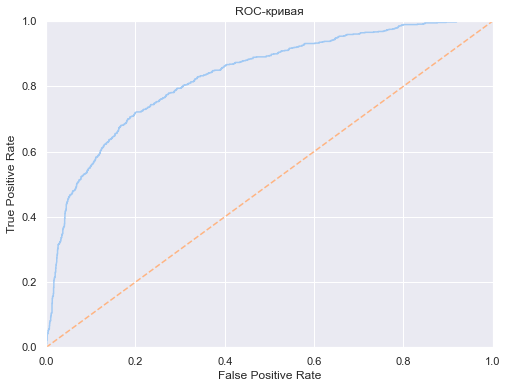

F1: 0.595
ROC_auc: 0.71
Precision: 0.784
Recall: 0.479


In [72]:
results(model_catboost_class_bow, X_test_bow, y_test_class)

### Подводим итоги по моделям классификации

На мой взгляд, нам удались модели классификации. Метрика F1 предсказана на высоком уровне более 0,6. Сведем результаты в таблице и взглянем на результаты на тестовых выборках.

In [73]:
#Проверка на тестовой BOW
f1_lgbm_test_bow = f1_score(y_test_class, prediction_lgbm_class_bow)
print('F1 test LightGBM on BOW: ', f1_lgbm_test_bow)

F1 test LightGBM on BOW:  0.6271829916476841


In [74]:
#Проверка на тестовой TF-IDF
f1_lgbm_test_tfidf = f1_score(y_test_class, prediction_lgbm_class_tfidf)
print('F1 test LightGBM on TF-IDF: ', f1_lgbm_test_tfidf)

F1 test LightGBM on TF-IDF:  0.6183719193427931


In [75]:
#Проверка на тестовой Random Forest
prediction_rf_classifier = model_rf_class.predict(X_test_bow)
f1_rf = f1_score(y_test_class, prediction_rf_classifier)
print('F1 test Random Forest: ', f1_rf)

F1 test Random Forest:  0.5018315018315018


In [76]:
#Проверка на тестовой BOW
f1_catboost_test_bow = f1_score(y_test_class, prediction_catboost_class_bow)
print('F1 test CatBoost: ', f1_catboost_test_bow)

F1 test CatBoost:  0.5945945945945945


In [77]:
metric_table2 = pd.DataFrame(data=[
    (round(f1_lgbm_bow_cv, 3), round(f1_lgbm_test_bow, 3)),
    (round(f1_lgbm_tfidf_cv, 3), round(f1_lgbm_test_tfidf, 3)),
    (round(study1.best_value, 3), round(f1_rf, 3)), 
    (round(f1_catboost_bow_cv, 3), round(f1_catboost_test_bow, 3))
], index=['LightGBM on BOW', 'LightGBM on TF-IDF', 'RandomForest', 'CatBoost'], columns=['F1 on CV', 'F1 on Test'])

display(metric_table2)

,F1 on CV,F1 on Test
LightGBM on BOW,0.622,0.627
LightGBM on TF-IDF,0.614,0.618
RandomForest,0.498,0.502
CatBoost,0.595,0.595


Все модели удались и достаточно адекватны. Модель LightGBM on BOW выдает хорошие метрики, на ней остановимся. Посмотрим, какие слова выделила эта модель.

In [78]:
feature_importances_class = sorted(zip(model_lgbm_class_bow.best_estimator_.feature_importances_, bow_features), 
                                   reverse=True)[0:40]
feature_importances_class

[(269, 'выставка'),
 (269, 'библиотека'),
 (262, 'год'),
 (222, 'который'),
 (150, 'наш'),
 (149, 'искусство'),
 (135, 'день'),
 (125, 'музей'),
 (117, 'работа'),
 (109, 'донский'),
 (106, 'вход'),
 (105, 'художник'),
 (104, 'центр'),
 (96, 'ростовский'),
 (94, 'свой'),
 (84, 'ростов'),
 (78, 'мсиида'),
 (74, 'публичный'),
 (71, 'это'),
 (70, 'проект'),
 (67, 'свободный'),
 (67, 'история'),
 (64, 'донскиехудожник'),
 (60, 'театр'),
 (55, 'лекция'),
 (53, 'пройти'),
 (53, 'время'),
 (53, 'space'),
 (52, 'состояться'),
 (48, 'россия'),
 (48, 'открытие'),
 (47, 'club'),
 (45, 'город'),
 (45, 'https'),
 (44, 'книга'),
 (43, 'весь'),
 (43, 'автор'),
 (42, 'рамка'),
 (41, 'человек'),
 (41, 'первый')]

# Вывод по данной работе

Мы получили список слов, которые, по мнению модели классификации, сильнее всего влияют на популярность поста. Теперь нам нужно свести два списка с популярными словами и сравнить их.

In [79]:
def words_plot(feature_importances, name_of_model):
    df = pd.DataFrame(feature_importances, columns=['importance', 'word'])
    df.set_index('word', inplace=True)
    df.sort_values(by='importance').plot(kind='barh', figsize=(10, 10))
    plt.title(f'График важности слов для модели {name_of_model}')
    plt.tight_layout()
    plt.show()

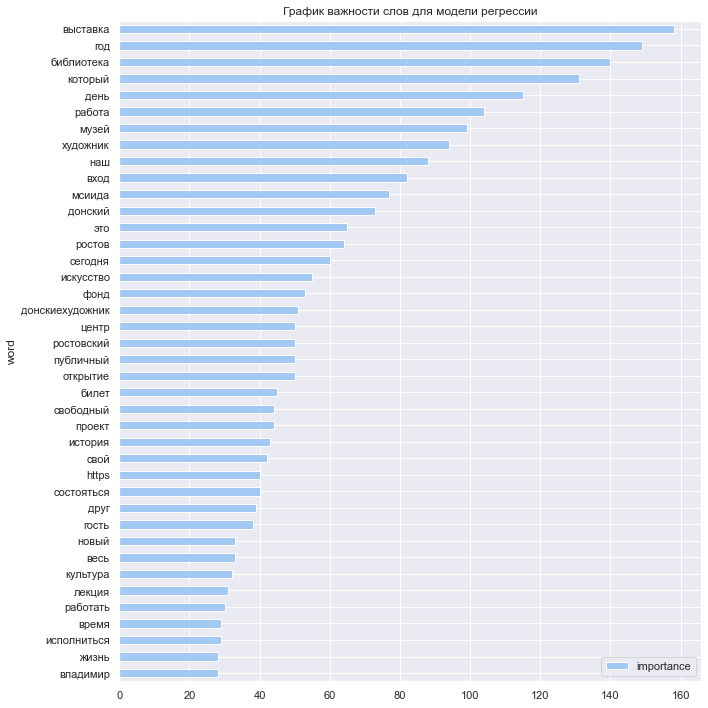

In [80]:
words_plot(feature_importances_reg, 'регрессии')

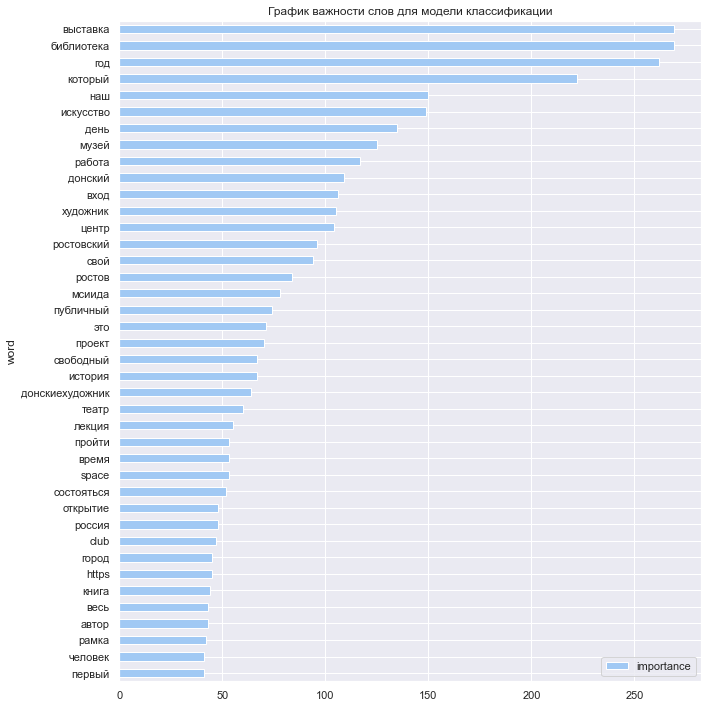

In [81]:
words_plot(feature_importances_class, 'классификации')

Как видим, есть некоторые различия в наборе слов. Далее мы разберем какие слова содержатся в обоих сетах и отберем содержательные.

In [82]:
words_reg = []
for tup in feature_importances_reg:
    words_reg.append(tup[1])
words_reg

['выставка',
 'год',
 'библиотека',
 'который',
 'день',
 'работа',
 'музей',
 'художник',
 'наш',
 'вход',
 'мсиида',
 'донский',
 'это',
 'ростов',
 'сегодня',
 'искусство',
 'фонд',
 'донскиехудожник',
 'центр',
 'ростовский',
 'публичный',
 'открытие',
 'билет',
 'свободный',
 'проект',
 'история',
 'свой',
 'состояться',
 'https',
 'друг',
 'гость',
 'новый',
 'весь',
 'культура',
 'лекция',
 'работать',
 'исполниться',
 'время',
 'жизнь',
 'владимир']

In [83]:
words_class = []
for tup in feature_importances_class:
    words_class.append(tup[1])
words_class

['выставка',
 'библиотека',
 'год',
 'который',
 'наш',
 'искусство',
 'день',
 'музей',
 'работа',
 'донский',
 'вход',
 'художник',
 'центр',
 'ростовский',
 'свой',
 'ростов',
 'мсиида',
 'публичный',
 'это',
 'проект',
 'свободный',
 'история',
 'донскиехудожник',
 'театр',
 'лекция',
 'пройти',
 'время',
 'space',
 'состояться',
 'россия',
 'открытие',
 'club',
 'город',
 'https',
 'книга',
 'весь',
 'автор',
 'рамка',
 'человек',
 'первый']

In [84]:
set_of_words = set(words_reg) & set(words_class)

In [85]:
set_of_words

{'https',
 'библиотека',
 'весь',
 'время',
 'вход',
 'выставка',
 'год',
 'день',
 'донскиехудожник',
 'донский',
 'искусство',
 'история',
 'который',
 'лекция',
 'мсиида',
 'музей',
 'наш',
 'открытие',
 'проект',
 'публичный',
 'работа',
 'ростов',
 'ростовский',
 'свободный',
 'свой',
 'состояться',
 'художник',
 'центр',
 'это'}

**Вывод:**
- Если отбросить все мусорные слова, то мы можем заметить, что люди обращают внимание на активности, выставки, музеи, библиотеки и тд.
- Они также обращают внимание на место проведения, город.
- Людям важно, чтобы это было в территориальной доступности.
- Важно описать обстоятельства посещения, покупки билетов, времени, входа и тд. 
- Люди в целом падки на громкие слова, вроде "центр", "фонд", "проект", "искусство" как возможность прикоснуться к чему то серьезному.
- Оценят свободное посещение.
- Всегда нужно уточнять время и даты, день, год мероприятия.

На данном этапе это все, что можно было вывести из данного исследования. Мы продолжим исследование на заранее подготовленном датафрейме в новой тетрадке Jupyter Notebook `social_networks2`. Цель - углубиться в исследование и выявить насколько важны иные метрики поста для его популярности среди пользователей.